In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import pandas as pd
import numpy as np
import astropy.units as u
from datetime import date
from random import choices
from math import factorial, erf
from astroquery.simbad import Simbad
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm, uniform
import h5py
from sklearn.neighbors import KernelDensity
from scipy.integrate import simps
from scipy import stats
from matplotlib.ticker import AutoMinorLocator
from astropy.io import ascii
from IPython.display import clear_output


In [2]:
def make_cmap(colors, position, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    bit_rgb = np.linspace(0,1,256)
    # if position == None:
    #     position = np.linspace(0,1,len(colors))
    # else:
    if len(position) != len(colors):
        sys.exit("position length must be the same as colors")
    elif position[0] != 0 or position[-1] != 1:
        sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap
def choose_cmap(custom_cmap, reverse_cmap=False):

    custom_cmaps = {'primordial disks': [(0/255, 26/255, 26/255),
                                         (41/255, 163/255, 163/255),
                                         (179/255, 255/255, 217/255)],
                    'debris disks': [(15/255, 15/255, 62/255),
                                      (102/255, 102/255, 255/255),
                                      (255/255, 204/255, 255/255)],
                    'hot jupiters': [(15/255, 15/255, 62/255),
                                     (102/255, 102/255, 255/255),
                                     (255/255, 250/255, 255/255)],
                    'warm jupiters': [(51/255, 26/255, 0/255),
                                      (255/255, 80/255, 80/255),
                                      (255/255, 255/255, 204/255)],
                    'cyber grape': [(51/255, 0/255, 51/255),
                                    (128/255, 0/255, 128/255),
                                    (153/255, 102/255, 255/255),
                                    (204/255, 255/255, 255/255)],
                    }

    chosen_cmap = custom_cmaps[custom_cmap]
    pos_diff = 1./(len(chosen_cmap)-1)
    positions = np.arange(0, 1+pos_diff, pos_diff)
    if reverse_cmap == True:
        chosen_cmap = chosen_cmap[::-1]
    mycolormap = make_cmap(chosen_cmap, position=positions)

    return mycolormap

plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')
# plt.rcParams.keys()

Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.


In [3]:
def unique(list_of_values):
    unique_values = []
    for _, value in enumerate(list_of_values):
        if value in unique_values:
            pass
        else:
            unique_values.append(value)
    return unique_values

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def factorial(number):
    fact = 1
    for i in range(1, number+1):
        fact = fact * i
    return fact

def weighted_mean(meas, meas_err):
    try:
        weight = 1./(np.array(meas_err)**2)
    except:
        print('Error calculating weighted mean!')
        print(meas, ',', meas_err)
    else:
        w_mean = sum(weight * np.array(meas)) / sum(weight)
        w_mean_err = 1./np.sqrt(sum(weight))

    return w_mean, w_mean_err

def i_unc(x, PDF):
    CDF = []
    for x_i in range(len(x)):
        CDF.append(np.trapz(PDF[0:x_i], x[0:x_i]))

    # plt.plot(x, CDF)

    where_peak = np.where(PDF == max(PDF))[0][0]
    sig1_perc = 1 - 0.6826
    sig2_perc = 1 - 0.9544
    sig1_sub = abs(np.array(CDF) - sig1_perc)
    sig2_sub = abs(np.array(CDF) - sig2_perc)

    where_sig1 = np.where(sig1_sub == min(sig1_sub))[0]
    where_sig2 = np.where(sig2_sub == min(sig2_sub))[0]
    sig1 = x[where_peak] - x[where_sig1]
    sig2 = x[where_peak] - x[where_sig2]

    if len(sig1) > 1:
        sig1 = float('nan')
        sig2 = float('nan')
    else:
        sig1 = sig1[0]
        sig2 = sig2[0]

    return sig1, sig2

def sigfig(value, uncertainty, return_uncertainty=True, cutoff=35):
    exp = np.floor(np.log10(uncertainty))
    if uncertainty / 10**(exp - 1) < cutoff:
        exp -= 1
    
    exp *= -1
    exp = int(exp)

    value_rounded = round(value, exp)

    # needed to avoid -0.0 being printed in table
    value_rounded_str = str(value_rounded)
    value_rounded_str_only_digits = value_rounded_str.replace('.', '').replace('-', '')
    if value_rounded_str.find('-') != -1 and value_rounded_str_only_digits == len(value_rounded_str_only_digits) * '0':
        value_rounded *= -1

    uncertainty_rounded = round(uncertainty, exp)
    
    if uncertainty_rounded < cutoff / 10:
        # in this case, exp represents number of decimal places to include
        output_tuple = f"{value_rounded:.{exp}f}", f"{uncertainty_rounded:.{exp}f}"
        return output_tuple if return_uncertainty else output_tuple[0]
    else:
        output_tuple = f"{int(value_rounded)}", f"{int(uncertainty_rounded)}"
        return output_tuple if return_uncertainty else output_tuple[0]

def quantile(x, q, weights=None):
    """
    Compute sample quantiles with support for weighted samples.
    Note
    ----
    When ``weights`` is ``None``, this method simply calls numpy's percentile
    function with the values of ``q`` multiplied by 100.
    Parameters
    ----------
    x : array_like[nsamples,]
       The samples.
    q : array_like[nquantiles,]
       The list of quantiles to compute. These should all be in the range
       ``[0, 1]``.
    weights : Optional[array_like[nsamples,]]
        An optional weight corresponding to each sample. These
    Returns
    -------
    quantiles : array_like[nquantiles,]
        The sample quantiles computed at ``q``.
    Raises
    ------
    ValueError
        For invalid quantiles; ``q`` not in ``[0, 1]`` or dimension mismatch
        between ``x`` and ``weights``.
    """
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if np.any(q < 0.0) or np.any(q > 1.0):
        raise ValueError("Quantiles must be between 0 and 1")
    
    if weights is None:
        return np.percentile(x, list(100.0 * q))
    else:
        weights = np.atleast_1d(weights)
        if len(x) != len(weights):
            raise ValueError("Dimension mismatch: len(weights) != len(x)")
        idx = np.argsort(x)
        sw = weights[idx]
        cdf = np.cumsum(sw)[:-1]
        cdf /= cdf[-1]
        cdf = np.append(0, cdf)
        return np.interp(q, cdf, x[idx]).tolist()

def median_pm_confidence_interval(x, pdf_y, sigma=0.6826):
    """
    Calculates output for median +- 1 sigma column.
    Parameters
    ----------
    par_chain : array_like
        Array of parameter
    sigma_per : float, optional
        Area under +- 1 sigma
    
    Returns
    -------
    str : Latex expression to go in final table
    """
    lower_bound, median, upper_bound = quantile(x, [0.5 - sigma / 2, 0.5, 0.5 + sigma / 2], pdf_y)

    if np.isnan(median) == False:
        lower_sig = abs(median - lower_bound)
        upper_sig = abs(upper_bound - median)
    else:
        median = float('nan')
        lower_sig = float('nan')
        upper_sig = float('nan')

    # if median == 0.:
    #     lower_sig = 0
    # elif lower_sig > mode:
    #     lower_sig = mode
    # if median == 90:
    #     upper_sig = 0
    # elif upper_sig > 90 - mode:
    #     upper_sig = 90 - mode

    return median, lower_sig, upper_sig

def mode_pm_highest_density_interval(x, pdf_y, sigma, return_pdf=False):
    # 1sigma makes sigma = 0.6826

    x_interp = np.arange(0, 90+0.01, 0.001)
    pdf_y = np.interp(x=x_interp, xp=x, fp=pdf_y)
    x = x_interp

    cdf_y = np.cumsum(pdf_y)
    cdf_y = cdf_y / cdf_y[-1]  # Normalize the cdf so that it sums to 1.

    delta_xlist = []
    xlower = []
    xupper = []

    sigma_lower = 0
    delta = 1e-6

    for _ in range(0,round((1 - sigma)/delta)):
        x1 = np.interp(sigma_lower,cdf_y,x)
        xu = np.interp(sigma,cdf_y,x)
        delta_xlist.append(xu-x1)
        xlower.append(x1)
        xupper.append(xu)
        sigma += delta
        sigma_lower += delta

    index = delta_xlist.index(min(delta_xlist))
    mode = np.mean(x[pdf_y == max(pdf_y)]).round(1)
    mode = x[pdf_y == max(pdf_y)]
    if len(mode) > 1:
        mode = np.mean(mode)
    else:
        mode = mode[0]
    # print('The lower x value (for minimum credible interval) is ', xlower[index])
    # print('The upper x value (for minimum credible interval) is ', xupper[index])

    lower = mode - xlower[index]
    upper = xupper[index] - mode

    if return_pdf == True:
        return mode, lower, upper, x, pdf_y
    if return_pdf == False:
        return mode, lower, upper

def SpType_num_to_str(sptype_num, sptype_num_err):

    sptype_base_num = int(np.floor(sptype_num))

    if sptype_base_num == 3:
        sptype_str_letter = 'G'
    if sptype_base_num == 4:
        sptype_str_letter = 'K'
    if sptype_base_num == 5:
        sptype_str_letter = 'M'

    sptype_cat_num = np.round((sptype_num - sptype_base_num) * 10, 1)
    sptype_cat_str = str(sptype_cat_num)

    sptype_str = sptype_str_letter + sptype_cat_str

    sptype_num_err = np.round(sptype_num_err * 10, 1)
    if sptype_num_err == 0.0:
        sptype_num_err = 0.01
    sptype_str_err = str(sptype_num_err)

    return sptype_str, sptype_str_err

def determine_sptype(let_val, num_val):

    possible_letters = {'B': 0,
                        'A': 1,
                        'F': 2,
                        'G': 3,
                        'K': 4,
                        'M':5,
                        }

    temp_val = []
    if '-' in let_val:
        let_val_split = str(let_val).replace(' ', '').split('-')
        num_val_split = str(num_val).replace(' ', '').split('-')
        val1 = possible_letters[let_val_split[0]] + 0.1*float(num_val_split[0])
        val2 = possible_letters[let_val_split[1]] + 0.1*float(num_val_split[1])
        temp_val = [val1, val2]
    else:
        temp_val.append(possible_letters[let_val] + 0.1*float(num_val))
    
    if len(temp_val) > 1:
        adopted_val = np.mean(temp_val)
        adopted_val_err = np.std(temp_val, ddof=1)
    if len(temp_val) == 1:
        adopted_val = temp_val[0]
        adopted_val_err = 0.1

    
    return adopted_val, adopted_val_err

def clean_dataframe(df, dataset):
    keep_columns = ['Target',
                    'SpType', 'SpType Unc', 'SpType Letter', 'SpType Letter Unc',
                    'Teff (K)', 'Teff Unc',
                    'Mstar (Msun)', 'Mstar Unc',
                    'Rstar (Rsun)', 'Rstar Unc',
                    'Prot (d)', 'Prot Unc',
                    'vsini (km/s)', 'vsini Unc',
                    'i disk (deg)', 'i disk Unc',
                    ]
    dict_clean = {}
    for _, key in enumerate(keep_columns):
        dict_clean[key] = []
    for _, col in enumerate(df.columns):
        if col == 'Target':
            targets = df['Target'].values
            for _, targ in enumerate(targets):
                dict_clean['Target'].append(targ)
        elif col == 'i disk Unc' or col == 'SpType Letter' or col == 'vsini Unc':
            if dataset != 'biddle':
                continue
            else:
                if col == 'i disk Unc' or col == 'vsini Unc':
                    continue
        elif col == 'SpType':
            sptype_strings = df['SpType'].values
            sptype_letters = df['SpType Letter'].values
            sptype_numbers = df['SpType Number'].values
            for index in range(len(sptype_letters)):
                updated_val, updated_val_err = determine_sptype(sptype_letters[index], sptype_numbers[index])
                dict_clean['SpType'].append(updated_val)
                if dataset != 'biddle':
                    dict_clean['SpType Unc'].append(updated_val_err)
                dict_clean['SpType Letter'].append(sptype_strings[index])
                dict_clean['SpType Letter Unc'].append(10 * updated_val_err)
        elif col == 'i disk (deg)':
            idisk_strings = df['i disk (deg)'].values
            idisk_err_strings = df['i disk Unc'].values
            for index in range(len(idisk_strings)):
                idisk_str = idisk_strings[index]
                idisk_err_str = idisk_err_strings[index]
                if type(idisk_str) == str:
                    if '[' in idisk_str:
                        val1 = float(idisk_str.replace('[', '').replace(']', '').split(',')[0])
                        val2 = float(idisk_str.replace('[', '').replace(']', '').split(',')[1])
                        val = np.mean([val1, val2])
                        val_err = abs(val - val1)
                    else:
                        val = float(idisk_str)
                        val_err = float(idisk_err_str)
                else:
                    val = idisk_str
                    val_err = idisk_err_str
                dict_clean['i disk (deg)'].append(val)
                dict_clean['i disk Unc'].append(val_err)
        elif col == 'vsini (km/s)':
            vsini_strings = df['vsini (km/s)'].values
            vsini_err_strings = df['vsini Unc'].values
            for index in range(len(vsini_strings)):
                vsini_str = vsini_strings[index]
                vsini_err_str = vsini_err_strings[index]
                if type(vsini_str) == str:
                    if '<' in vsini_str:
                        val = float(vsini_str.replace('<', ''))
                        val_err = 'ulimit'
                    else:
                        val = float(vsini_str)
                        val_err = float(vsini_err_str)
                else:
                    val = float(vsini_str)
                    val_err = float(vsini_err_str)
                dict_clean['vsini (km/s)'].append(val)
                dict_clean['vsini Unc'].append(val_err)
        elif col in keep_columns:
            vals = df[col].values
            for _, val_str in enumerate(vals):
                val = float(val_str)
                dict_clean[col].append(val)
        else:
            continue

    # if dataset == 'biddle':
    #     for _, key in enumerate(dict_clean.keys()):
    #         print(key, len(dict_clean[key]))
    
    df_clean = pd.DataFrame(dict_clean)
    
    return df_clean









In [4]:
customSimbad = Simbad()
customSimbad.add_votable_fields('ra(2;A;ICRS;J2017.5;2000)', 'dec(2;D;ICRS;J2017.5;2000)',
                                'sp', 'sp_nature', 'sp_bibcode',
                                'flux(R)', 'flux(I)', 'flux(V)', 'flux(K)')
customSimbad.remove_votable_fields('coordinates')
customSimbad.TIMEOUT = 4 * 60 # sets the timeout to 4 min
customSimbad.ROW_LIMIT = -1

In [131]:
main_directory = '/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/'
data_directory = main_directory+'Tables/Condensed_Sample_By_Date/'
tables_dictionary = main_directory+'Tables'
test_figures_directory = main_directory + 'Test_Figures/'
final_figures_directory = main_directory + 'Final_Figures/'





In [6]:
read_local = False

if read_local != True:
    today = date.today()
    date_str = today.strftime("%Y-%b-%d")

    biddle_properties_sheet_url = "https://docs.google.com/spreadsheets/d/1Xjpm2m3hxQACorlvKcwqjBnBKssgK8MCFyijPfVseFg/edit#gid=0"
    hurt_properties_sheet_url = "https://docs.google.com/spreadsheets/d/1Lz2p6EdhytAR2_HvcPY543MrRbRoB7d7Hj5yp1E8XsM/edit#gid=0"
    morgan_properties_HJ_sheet_url = "https://docs.google.com/spreadsheets/d/1k5oKAUum9d-s5JaD3HDRDlMZqn_pPGvRyFvB4kw8WE0/edit#gid=0"
    morgan_properties_WJ_sheet_url = "https://docs.google.com/spreadsheets/d/1B8ep95z7EaXZ6x-fRjntDTN3i8LQUmNRGMBrc5G6bV4/edit#gid=0"


    url_biddle_properties = biddle_properties_sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
    url_hurt_properties = hurt_properties_sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
    url_morgan_properties_HJ = morgan_properties_HJ_sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
    url_morgan_properties_WJ = morgan_properties_WJ_sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

    df_biddle_goog = pd.read_csv(url_biddle_properties)
    df_hurt_goog = pd.read_csv(url_hurt_properties)
    df_morgan_HJ_goog = pd.read_csv(url_morgan_properties_HJ)
    df_morgan_WJ_goog = pd.read_csv(url_morgan_properties_WJ)


else:
    date_str = '2023-Dec-9'
    raw_df = pd.read_excel(main_directory + 'Primordial_Disks_9-Dec-2023.xlsx')

date_str

'2024-Jul-07'

In [7]:
run_last_few_objects = False
if run_last_few_objects == True:
    min_object = 'WSB 52'

    min_index_stassun = np.where(df_stassun_goog['Target'].values == min_object)[0][0]
    df_stassun_goog = df_stassun_goog[df_stassun_goog.index >= min_index_stassun]

    min_index_hurt = np.where(df_hurt_goog['Target'].values == min_object)[0][0]
    df_hurt_goog = df_hurt_goog[df_hurt_goog.index >= min_index_hurt]

run_first_few_objects = False
if run_first_few_objects == True:
    max_object = '2MASS J04322210+1827426'

    max_index_stassun = np.where(df_stassun_goog['Target'].values == max_object)[0][0]
    df_stassun_goog = df_stassun_goog[df_stassun_goog.index < max_index_stassun]

    max_index_hurt = np.where(df_hurt_goog['Target'].values == max_object)[0][0]
    df_hurt_goog = df_hurt_goog[df_hurt_goog.index < max_index_hurt]


In [8]:
compute_new_posteriors = False

if compute_new_posteriors == False:
    date_str = '2024-Jun-05'

skip_biddle = False
skip_hurt = False
skip_morgan = False

sampling_resolution = 'med'
resolution_text = sampling_resolution + 'Res'
if sampling_resolution == 'high':
    probability_distributions_dir = main_directory + 'Tables/Probability_Distributions/High/'
if sampling_resolution == 'med':
    probability_distributions_dir = main_directory + 'Tables/Probability_Distributions/Med/'
if sampling_resolution == 'low':
    probability_distributions_dir = main_directory + 'Tables/Probability_Distributions/Low/'

do_save_probability_distributions = True
do_save_plots = True

plot_lightfigure = False
plot_transparent = False

if plot_lightfigure == True:
    hist_linecolor = '#9e0da5'  # Histogram
    point_color = '#b3d9ff'  # veq - vsini
    zeroline_color = '#e6e6e6'  # veq - vsini
    edge_color = '#b3d9ff'  # par vs. Delta i 
    point_color_no_z = '#b3d9ff'  # par vs. Delta i 
    kde_color = '#6fdcdc'
    
    plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle_light.mplstyle')
else:
    hist_linecolor = '#2f0431'  # Histogram
    zeroline_color = '#404040'  # veq - vsini
    point_color = '#003366'   # veq - vsini
    edge_color = '#005580'  # par vs. Delta i 
    point_color_no_z = '#0086b3'  # par vs. Delta i 
    kde_color = '#6fdcdc'
    
    plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')

if plot_transparent == True:
    transparent_text = 'transparent'
else:
    transparent_text = 'opaque'

if plot_lightfigure == True:
    light_or_dark_dext = 'light'
else:
    light_or_dark_dext = 'dark'


print('\nUsing date_str = ' + date_str + '\n')

save_csv_filepath_biddle = data_directory + 'adopted_' + resolution_text + '_biddle_' + date_str + '.csv'
save_csv_filepath_hurt = data_directory + 'adopted_' + resolution_text + '_hurt_' + date_str + '.csv'
save_csv_filepath_morgan_HJ = data_directory + 'adopted_' + resolution_text + '_morgan_HJ_' + date_str + '.csv'
save_csv_filepath_morgan_WJ = data_directory + 'adopted_' + resolution_text + '_morgan_WJ_' + date_str + '.csv'


if compute_new_posteriors == True:
    if skip_biddle != True:
        print('TABLE WITH BIDDLE PROPERTIES WIILL BE SAVED TO: ', save_csv_filepath_biddle.split('/')[-1])
    if skip_hurt != True:
        print('TABLE WITH HURT PROPERTIES WIILL BE SAVED TO: ', save_csv_filepath_hurt.split('/')[-1])
    if skip_morgan != True:
        print('TABLE WITH MORGAN HJ PROPERTIES WIILL BE SAVED TO: ', save_csv_filepath_morgan_HJ.split('/')[-1])
        print('TABLE WITH MORGAN WJ PROPERTIES WIILL BE SAVED TO: ', save_csv_filepath_morgan_WJ.split('/')[-1])


Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.



Using date_str = 2024-Jun-05



In [9]:

def compute_obliquities(df, which_list, resolution, posteriors_csv_dir, posteriors_fig_dir, save_stuff, plot_stuff):


    target_list = df['Target'].values

    if resolution == 'high':
        n_draws = int(5e6)
        sampling_res = 0.01
        smooth_over_deg = 0.5
    elif resolution == 'med':
        n_draws = int(1e6)
        sampling_res = 0.5
        smooth_over_deg = 3
    else:
        n_draws = int(1e4)
        sampling_res = 1.0
        smooth_over_deg = 5
    
    istars = np.arange(0, 90+sampling_res, sampling_res)
    i_bins = np.concatenate((istars, np.array([istars[-1] + sampling_res])))



    istar = []
    istar_err_p = []
    istar_err_m = []
    idiff = []
    idiff_err_p = []
    idiff_err_m = []
    eq_vel = []
    eq_vel_err = []
    for targ_i, target in enumerate(target_list):

        print('~~~~~~~~~~~~~~~~~~~~~~ ' + which_list + ' ~~~~~~~~~~~~~~~~~~~~~~')
        print(target)

        target_str = target.replace(' ', '')

        # ------------------------------------------------------------------------------------- #
        # ---------------------- COMPUTE i STAR PROBABILITY DISTRIBUTION ---------------------- #
        # ------------------------------------------------------------------------------------- #
        vsini = df['vsini (km/s)'].values[targ_i]
        sigma_vsini = df['vsini Unc'].values[targ_i]

        Prot = (df['Prot (d)'].values[targ_i] * u.d).to(u.s).value
        sigma_Prot = (df['Prot Unc'].values[targ_i] * u.d).to(u.s).value
        
        Rstar = (df['Rstar (Rsun)'].values[targ_i] * u.Rsun).to(u.km).value
        sigma_Rstar = (df['Rstar Unc'].values[targ_i] * u.Rsun).to(u.km).value

        veq = (2 * np.pi * Rstar)/(Prot)
        sigma_veq = veq * np.sqrt((sigma_Rstar/Rstar)**2 + (sigma_Prot/Prot)**2)

        sini = np.sin(np.radians(istars))

        if sigma_vsini != 'ulimit':
            # print(vsini, type(vsini))
            # print(veq, type(veq))
            # print(sini, type(sini))
            part1 = vsini - veq * sini
            part2 = 2 * (sigma_vsini**2 + sigma_veq**2 * sini**2)
            i_star_dist = sini * (np.exp(-(part1**2)/part2))/np.sqrt(part2)
        else:
            i_star_dist_list = []
            for sini_element in range(len(sini)):
                part1 = vsini - veq * sini[sini_element]
                part2 = np.sqrt(2) * sigma_veq * sini[sini_element]
                part3 = np.sqrt(2) * np.pi * Rstar
                part4 = sigma_veq * Prot
                istar_element = sini[sini_element] * (erf(part1/part2) + erf(part3/part4))
                i_star_dist_list.append(istar_element)
            i_star_dist = np.array(i_star_dist_list)

        istars = istars[np.isnan(i_star_dist) == False]
        i_star_dist = i_star_dist[np.isnan(i_star_dist) == False]

        i_star_dist = i_star_dist / (sum(i_star_dist) * sampling_res)

        # -------------------------------- i STAR UNCERTAINTY --------------------------------- #
        i_star_MAP, sig1_i_star_m, sig1_i_star_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_star_dist, sigma=0.6826)
        _, sig2_i_star_m, sig2_i_star_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_star_dist, sigma=0.9540)




        # ------------------------------------------------------------------------------------- #
        # ---------------------- COMPUTE i DISK PROBABILITY DISTRIBUTION ---------------------- #
        # ------------------------------------------------------------------------------------- #

        disk_val = df['i disk (deg)'].values[targ_i]
        if type(disk_val) == str:
            disk_val = disk_val.replace('[', '')
            disk_val = disk_val.replace(']', '')
            disk_val_min = float(disk_val.split(',')[0])
            disk_val_max = float(disk_val.split(',')[1])
            i_disk_dist = uniform.pdf(x=istars, loc=disk_val_min, scale=disk_val_max-disk_val_min)
            # -------------------------------- i DISK UNCERTAINTY --------------------------------- #
            i_disk_MAP = 0.5 * (disk_val_max - disk_val_min)
            sig1_i_disk_m = abs(i_disk_MAP - disk_val_min)
            sig1_i_disk_p = abs(disk_val_max - i_disk_MAP)
            sig2_i_disk_m = sig1_i_disk_m
            sig2_i_disk_p = sig1_i_disk_p
        else:
            i_disk_dist = norm.pdf(x=istars, loc=df['i disk (deg)'].values[targ_i], scale=df['i disk Unc'].values[targ_i])
            # -------------------------------- i DISK UNCERTAINTY --------------------------------- #
            i_disk_MAP, sig1_i_disk_m, sig1_i_disk_p = df['i disk (deg)'].values[targ_i], df['i disk Unc'].values[targ_i], df['i disk Unc'].values[targ_i]
            _, sig2_i_disk_m, sig2_i_disk_p = df['i disk (deg)'].values[targ_i], 2 * df['i disk Unc'].values[targ_i], 2 * df['i disk Unc'].values[targ_i]




        # ------------------------------------------------------------------------------------- #
        # --------------------- COMPUTE DELTA i PROBABILITY DISTRIBUTION ---------------------- #
        # ------------------------------------------------------------------------------------- #
        i_disk_rand = choices(istars, i_disk_dist, k=n_draws)
        i_star_rand = choices(istars, i_star_dist, k=n_draws)
        i_diff_rand = abs(np.array(i_disk_rand) - i_star_rand)

        bin_vals_i_diff, _ = np.histogram(i_diff_rand, bins=i_bins)  # , density=True)

        smooth_over_points = int(smooth_over_deg/sampling_res)
        smooth_vals_i_diff = gaussian_filter1d(bin_vals_i_diff, smooth_over_points)

        i_diff_dist_smooth = smooth_vals_i_diff / (sum(smooth_vals_i_diff) * sampling_res)
        i_diff_dist_rough = bin_vals_i_diff / (sum(bin_vals_i_diff) * sampling_res)

        smooth_on = True
        if smooth_on == True:
            i_diff_dist = np.copy(i_diff_dist_smooth)
        else:
            i_diff_dist = np.copy(i_diff_dist_rough)

        # -------------------------------- DELTA i UNCERTAINTY --------------------------------- #
        i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_diff_dist, sigma=0.6826)
        _, sig2_i_diff_m, sig2_i_diff_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_diff_dist, sigma=0.9540)








        # -------------------------------- SAVE STUFF --------------------------------- #
        if save_stuff == True:
            probability_densities = pd.DataFrame({'i (deg)':  istars,
                                                  'P(i Disk | d)': i_disk_dist,
                                                  'P(i Star | d)': i_star_dist,
                                                  'P(Delta i | d)': i_diff_dist_smooth,
                                                  'i Disk MAP' : [i_disk_MAP]*len(istars),
                                                  'i Disk -Unc1' : [sig1_i_disk_m]*len(istars),
                                                  'i Disk +Unc1' : [sig1_i_disk_p]*len(istars),
                                                  'i Disk -Unc2' : [sig2_i_disk_m]*len(istars),
                                                  'i Disk +Unc2' : [sig2_i_disk_p]*len(istars),
                                                  'i Star MAP' : [i_star_MAP]*len(istars),
                                                  'i Star -Unc1' : [sig1_i_star_m]*len(istars),
                                                  'i Star +Unc1' : [sig1_i_star_p]*len(istars),
                                                  'i Star -Unc2' : [sig2_i_star_m]*len(istars),
                                                  'i Star +Unc2' : [sig2_i_star_p]*len(istars),
                                                  'Delta i MAP' : [i_diff_MAP]*len(istars),
                                                  'Delta i -Unc1' : [sig1_i_diff_m]*len(istars),
                                                  'Delta i +Unc1' : [sig1_i_diff_p]*len(istars),
                                                  'Delta i -Unc2' : [sig2_i_diff_m]*len(istars),
                                                  'Delta i +Unc2' : [sig2_i_diff_p]*len(istars),
                                                  })
            
            probability_densities.to_csv(posteriors_csv_dir+ 'Posteriors_' + target_str + '_' + which_list + '.csv', index=False)

            probability_densities_rough = pd.DataFrame({'i (deg)':  istars,
                                                        'P(i Disk | d)': i_disk_dist,
                                                        'P(i Star | d)': i_star_dist,
                                                        'P(Delta i | d)': i_diff_dist_rough,
                                                        'i Disk MAP' : [i_disk_MAP]*len(istars),
                                                        'i Disk -Unc1' : [sig1_i_disk_m]*len(istars),
                                                        'i Disk +Unc1' : [sig1_i_disk_p]*len(istars),
                                                        'i Disk -Unc2' : [sig2_i_disk_m]*len(istars),
                                                        'i Disk +Unc2' : [sig2_i_disk_p]*len(istars),
                                                        'i Star MAP' : [i_star_MAP]*len(istars),
                                                        'i Star -Unc1' : [sig1_i_star_m]*len(istars),
                                                        'i Star +Unc1' : [sig1_i_star_p]*len(istars),
                                                        'i Star -Unc2' : [sig2_i_star_m]*len(istars),
                                                        'i Star +Unc2' : [sig2_i_star_p]*len(istars),
                                                        'Delta i MAP' : [i_diff_MAP]*len(istars),
                                                        'Delta i -Unc1' : [sig1_i_diff_m]*len(istars),
                                                        'Delta i +Unc1' : [sig1_i_diff_p]*len(istars),
                                                        'Delta i -Unc2' : [sig2_i_diff_m]*len(istars),
                                                        'Delta i +Unc2' : [sig2_i_diff_p]*len(istars),
                                                        })
            
            probability_densities_rough.to_csv(posteriors_csv_dir+ 'Posteriors_Rough_' + target_str + '_' + which_list + '.csv', index=False)







        print_stuff = True
        # -------------------------------- PRINT STUFF --------------------------------- #
        if print_stuff == True:
            print('i_disk: {:.2f} -/+{:.2f} '.format(i_disk_MAP, sig1_i_disk_p))
            print('i_star: {:.2f} -{:.2f} +{:.2f}'.format(i_star_MAP, sig1_i_star_m, sig1_i_star_p))
            print('i_diff: {:.2f} -{:.2f} +{:.2f}\n'.format(i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p))










        # -------------------------------- PLOT STUFF --------------------------------- #
        if plot_stuff == True:
            # ------------------------------------------------------------------------------------- #
            # ------------------------------------ PLOT i DISK ------------------------------------ #
            # ------------------------------------------------------------------------------------- #
            if len(np.where(np.isnan(i_disk_rand) == False)[0]) > 0:
                
                fig_i_disk_dist = plt.figure(figsize=(8, 7))
                ax = fig_i_disk_dist.add_axes([0.16, 0.12, 1-(0.16+0.04), 1-(0.12+0.05)])
                ax.set_title('Disk Inclination')
                ax.set_xlabel(r'$i_{disk}$ ($^\degree$)', labelpad=12)
                ax.set_ylabel(r'$P$ ($i_{disk}$ | $i$)', labelpad=12)
                ax.minorticks_on()

                # fill_color = '#3d4d5c'
                fill_color = '#cc8800'  # '#527a7a'
                fill_alpha_sig2 = 0.4
                fill_alpha_sig1 = 1 - fill_alpha_sig2
                
                sig1_idisk_val_l = i_disk_MAP - sig1_i_disk_m
                sig2_idisk_val_l = i_disk_MAP - sig2_i_disk_m
                sig1_sub_l = np.array(abs(istars - sig1_idisk_val_l))
                sig2_sub_l = np.array(abs(istars - sig2_idisk_val_l))
                where_sig1_l = np.where(sig1_sub_l == min(sig1_sub_l))[0][0]
                where_sig2_l = np.where(sig2_sub_l == min(sig2_sub_l))[0][0]

                sig1_idisk_val_r = i_disk_MAP + sig1_i_disk_p
                sig2_idisk_val_r = i_disk_MAP + sig2_i_disk_p
                sig1_sub_r = np.array(abs(istars - sig1_idisk_val_r))
                sig2_sub_r = np.array(abs(istars - sig2_idisk_val_r))
                where_sig1_r = np.where(sig1_sub_r == min(sig1_sub_r))[0][0]
                where_sig2_r = np.where(sig2_sub_r == min(sig2_sub_r))[0][0]

                ax.plot(istars, i_disk_dist, color='#000000', lw=4, zorder=2)

                where_fill_sig1 = np.where((istars >= istars[where_sig1_l]) & (istars <= istars[where_sig1_r]))
                where_fill_sig2 = np.where((istars >= istars[where_sig2_l]) & (istars <= istars[where_sig2_r]))
                ax.fill_between(istars[where_fill_sig1], [0.]*len(istars[where_fill_sig1]),
                                i_disk_dist[where_fill_sig1], color=fill_color, alpha=fill_alpha_sig1, zorder=-1)
                ax.fill_between(istars[where_fill_sig2], [0.]*len(istars[where_fill_sig2]),
                                i_disk_dist[where_fill_sig2], color=fill_color, alpha=fill_alpha_sig2, zorder=-1)

                ymin, ymax = 0, 1.20*max(i_disk_dist)
                xmin, xmax = 0, 90
                ax.set_ylim(ymin, ymax)
                ax.set_xlim(xmin, xmax)

                ax.set_xticks(np.arange(0, 90 + 15, 15))

                ax.text(0.03*xmax, 0.925*ymax, target,
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                ax.text(0.03*xmax, 0.875*ymax, r'$i_{disk}$  MAP = ' + '{:.2f} +/- {:.2f}'.format(i_disk_MAP, sig1_i_disk_p),
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                
                fig_i_disk_dist.savefig(posteriors_fig_dir + 'Inclinations/' + target_str + '_idisk.pdf')
                # plt.show
                plt.close()



            # ------------------------------------------------------------------------------------- #
            # ------------------------------------ PLOT i STAR ------------------------------------ #
            # ------------------------------------------------------------------------------------- #
            if np.isnan(np.nanmax(i_star_dist)) == False:

                fig_i_star = plt.figure(figsize=(8, 7))
                ax = fig_i_star.add_axes([0.16, 0.12, 1-(0.16+0.04), 1-(0.12+0.05)])
                ax.set_title('Stellar Inclination')
                ax.set_xlabel(r'$i_{*}$ ($^\degree$)', labelpad=12, fontsize=16)
                ax.set_ylabel(r'$P$ ($i_{*}$ | $P_{rot}$, $R_{*}$, $v\mathrm{sin}i$)', labelpad=12)
                ax.minorticks_on()

                ymin, ymax = 0, 1.20*max(i_star_dist)
                xmin, xmax = 0, 90

                fill_color = '#8542c5'  # '#739900'
                fill_alpha_sig2 = 0.4
                fill_alpha_sig1 = 1 - fill_alpha_sig2

                sig1_ival_l = i_star_MAP - sig1_i_star_m
                sig2_ival_l = i_star_MAP - sig2_i_star_m
                sig1_sub_l = np.array(abs(istars - sig1_ival_l))
                sig2_sub_l = np.array(abs(istars - sig2_ival_l))
                where_sig1_l = np.where(sig1_sub_l == min(sig1_sub_l))[0][0]
                where_sig2_l = np.where(sig2_sub_l == min(sig2_sub_l))[0][0]

                sig1_ival_r = i_star_MAP + sig1_i_star_p
                sig2_ival_r = i_star_MAP + sig2_i_star_p
                sig1_sub_r = np.array(abs(istars - sig1_ival_r))
                sig2_sub_r = np.array(abs(istars - sig2_ival_r))
                where_sig1_r = np.where(sig1_sub_r == min(sig1_sub_r))[0][0]
                where_sig2_r = np.where(sig2_sub_r == min(sig2_sub_r))[0][0]


                ax.plot(istars, i_star_dist, color='black', lw=4, zorder=1)

                where_fill_sig1 = np.where((istars >= istars[where_sig1_l]) & (istars <= istars[where_sig1_r]))
                where_fill_sig2 = np.where((istars >= istars[where_sig2_l]) & (istars <= istars[where_sig2_r]))
                ax.fill_between(istars[where_fill_sig1], [0.]*len(istars[where_fill_sig1]),
                                i_star_dist[where_fill_sig1], color=fill_color, alpha=fill_alpha_sig1, zorder=0)
                ax.fill_between(istars[where_fill_sig2], [0.]*len(istars[where_fill_sig2]),
                                i_star_dist[where_fill_sig2], color=fill_color, alpha=fill_alpha_sig2, zorder=0)


                ax.set_ylim(ymin, ymax)
                ax.set_xlim(xmin, xmax)
                ax.set_xticks(np.arange(0,105,15))

                ax.text(0.03*xmax, 0.925*ymax, target,
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                ax.text(0.03*xmax, 0.875*ymax, r'$i_*$  MAP' + ' = {:.2f}  -{:.2f}  +{:.2f}'.format(i_star_MAP, sig1_i_star_m, sig1_i_star_p),
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)

                fig_i_star.savefig(posteriors_fig_dir + 'Inclinations/' + target_str + '_istar.pdf')
                # plt.show()
                plt.close()



            # ------------------------------------------------------------------------------------- #
            # ----------------------------------- PLOT DELTA i ------------------------------------ #
            # ------------------------------------------------------------------------------------- #
            if len(np.where(np.isnan(i_diff_dist) == False)[0]) > 0:
                
                fig_i_diff_dist = plt.figure(figsize=(8, 7))
                ax = fig_i_diff_dist.add_axes([0.16, 0.12, 1-(0.16+0.04), 1-(0.12+0.05)])
                ax.set_title(r'Difference in $i$')
                ax.set_xlabel(r'$\Delta i$ ($^\degree$)', labelpad=12)
                ax.set_ylabel(r'$P$ ($\Delta i$ | $i_{*}$, $i_{disk}$)', labelpad=12)

                # fill_color = '#3d4d5c'
                fill_color = '#007399'
                fill_alpha_sig2 = 0.4
                fill_alpha_sig1 = 1 - fill_alpha_sig2


                sig1_diff_val_l = i_diff_MAP - sig1_i_diff_m
                sig2_diff_val_l = i_diff_MAP - sig2_i_diff_m
                sig1_sub_l = np.array(abs(istars - sig1_diff_val_l))
                sig2_sub_l = np.array(abs(istars - sig2_diff_val_l))
                where_sig1_l = np.where(sig1_sub_l == min(sig1_sub_l))[0][0]
                where_sig2_l = np.where(sig2_sub_l == min(sig2_sub_l))[0][0]

                sig1_idiff_val_r = i_diff_MAP + sig1_i_diff_p
                sig2_idiff_val_r = i_diff_MAP + sig2_i_diff_p
                sig1_sub_r = np.array(abs(istars - sig1_idiff_val_r))
                sig2_sub_r = np.array(abs(istars - sig2_idiff_val_r))
                where_sig1_r = np.where(sig1_sub_r == min(sig1_sub_r))[0][0]
                where_sig2_r = np.where(sig2_sub_r == min(sig2_sub_r))[0][0]


                ax.plot(istars, i_diff_dist, color='#000000', lw=4, zorder=2)
                # ax.plot([i_diff_MAP, i_diff_MAP], [0, max(i_diff_dist)], '--', color='#000000', lw=2, zorder=2)

                where_fill_sig1 = np.where((istars >= istars[where_sig1_l]) & (istars <= istars[where_sig1_r]))
                where_fill_sig2 = np.where((istars >= istars[where_sig2_l]) & (istars <= istars[where_sig2_r]))
                ax.fill_between(istars[where_fill_sig1], [0.]*len(istars[where_fill_sig1]),
                                i_diff_dist[where_fill_sig1], color=fill_color, alpha=fill_alpha_sig1, zorder=-1)
                ax.fill_between(istars[where_fill_sig2], [0.]*len(istars[where_fill_sig2]),
                                i_diff_dist[where_fill_sig2], color=fill_color, alpha=fill_alpha_sig2, zorder=-1)


                ymin, ymax = 0, 1.20*max(i_diff_dist)
                xmin, xmax = 0, 90
                ax.set_ylim(ymin, ymax)
                ax.set_xlim(xmin, xmax)

                ax.set_xticks(np.arange(0, 90 + 15, 15))

                ax.text(0.03*xmax, 0.925*ymax, target,
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                ax.text(0.03*xmax, 0.875*ymax, r'$\Delta i$  MAP = ' + '{:.2f}  -{:.2f}  +{:.2f}'.format(i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p),
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                    

                fig_i_diff_dist.savefig(posteriors_fig_dir + 'Inclinations/' + target_str + '_zDeltai.pdf')
                # plt.show()
                plt.close()


        istar.append(i_star_MAP)
        istar_err_p.append(sig1_i_star_p)
        istar_err_m.append(sig1_i_star_m)
        idiff.append(i_diff_MAP)
        idiff_err_p.append(sig1_i_diff_p)
        idiff_err_m.append(sig1_i_diff_m)
        eq_vel.append(veq)
        eq_vel_err.append(sigma_veq)
    
    df['i star (deg)'] = istar
    df['i star +Unc'] = istar_err_p
    df['i star -Unc'] = istar_err_m
    df['disk diff'] = idiff
    df['disk diff +Unc'] = idiff_err_p
    df['disk diff -Unc'] = idiff_err_m
    df['Veq'] = eq_vel
    df['Veq Unc'] = eq_vel_err

    return df


In [10]:
df_biddle_goog_clean = clean_dataframe(df=df_biddle_goog, dataset='biddle')
df_hurt_goog_clean = clean_dataframe(df=df_hurt_goog, dataset='hurt')
df_morgan_HJ_goog_clean = clean_dataframe(df=df_morgan_HJ_goog, dataset='morgan_HJ')
df_morgan_WJ_goog_clean = clean_dataframe(df=df_morgan_WJ_goog, dataset='morgan_WJ')

In [11]:

if compute_new_posteriors == True:

     # BIDDLE PROPERTIES
    if skip_biddle != True:
        df_biddle = compute_obliquities(df=df_biddle_goog_clean, which_list='biddle', resolution=sampling_resolution, posteriors_csv_dir=probability_distributions_dir, posteriors_fig_dir=test_figures_directory, save_stuff=do_save_probability_distributions, plot_stuff=do_save_plots)
        df_biddle.to_csv(save_csv_filepath_biddle, index=False)
        df_biddle = pd.read_csv(save_csv_filepath_biddle)
        df_biddle['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
        df_biddle['vsini Unc'] = df_biddle['vsini Unc'].astype(float)
        df_biddle = df_biddle.sort_values('Target')
        df_biddle.loc[df_biddle['i star (deg)'] > 90., 'i star (deg)'] = 90.


    # HURT PROPERTIES
    if skip_hurt != True:
        df_hurt = compute_obliquities(df=df_hurt_goog_clean, which_list='hurt', resolution=sampling_resolution, posteriors_csv_dir=probability_distributions_dir, posteriors_fig_dir=test_figures_directory, save_stuff=do_save_probability_distributions, plot_stuff=do_save_plots)
        df_hurt.to_csv(save_csv_filepath_hurt, index=False)
        df_hurt = pd.read_csv(save_csv_filepath_hurt)
        df_hurt['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
        df_hurt['vsini Unc'] = df_hurt['vsini Unc'].astype(float)
        df_hurt = df_hurt.sort_values('Target')
        df_hurt.loc[df_hurt['i star (deg)'] > 90., 'i star (deg)'] = 90.

    # MORGAN PROPERTIES
    if skip_morgan != True:
        df_morgan_WJ = compute_obliquities(df=df_morgan_WJ_goog_clean, which_list='morgan_WJ', resolution=sampling_resolution, posteriors_csv_dir=probability_distributions_dir, posteriors_fig_dir=test_figures_directory, save_stuff=do_save_probability_distributions, plot_stuff=do_save_plots)
        df_morgan_WJ.to_csv(save_csv_filepath_morgan_WJ, index=False)
        df_morgan_WJ = pd.read_csv(save_csv_filepath_morgan_WJ)
        df_morgan_WJ['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
        df_morgan_WJ['vsini Unc'] = df_morgan_WJ['vsini Unc'].astype(float)
        df_morgan_WJ = df_morgan_WJ.sort_values('Target')
        df_morgan_WJ.loc[df_morgan_WJ['i star (deg)'] > 90., 'i star (deg)'] = 90.

        df_morgan_HJ = compute_obliquities(df=df_morgan_HJ_goog_clean, which_list='morgan_HJ', resolution=sampling_resolution, posteriors_csv_dir=probability_distributions_dir, posteriors_fig_dir=test_figures_directory, save_stuff=do_save_probability_distributions, plot_stuff=do_save_plots)
        df_morgan_HJ.to_csv(save_csv_filepath_morgan_HJ, index=False)
        df_morgan_HJ = pd.read_csv(save_csv_filepath_morgan_HJ)
        df_morgan_HJ['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
        df_morgan_HJ['vsini Unc'] = df_morgan_HJ['vsini Unc'].astype(float)
        df_morgan_HJ = df_morgan_HJ.sort_values('Target')
        df_morgan_HJ.loc[df_morgan_HJ['i star (deg)'] > 90., 'i star (deg)'] = 90.

else:

    print('OPENING FILES...')

    # BIDDLE PROPERTIES
    if skip_biddle!= True:
        print(save_csv_filepath_biddle)
        df_biddle = pd.read_csv(save_csv_filepath_biddle)
        df_biddle['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
        df_biddle['vsini Unc'] = df_biddle['vsini Unc'].astype(float)
        df_biddle = df_biddle.sort_values('Target')
        df_biddle.loc[df_biddle['i star (deg)'] > 90., 'i star (deg)'] = 90.

    # HURT PROPERTIES 
    if skip_hurt != True:
        print(save_csv_filepath_hurt)
        df_hurt = pd.read_csv(save_csv_filepath_hurt)
        df_hurt['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
        df_hurt['vsini Unc'] = df_hurt['vsini Unc'].astype(float)
        df_hurt = df_hurt.sort_values('Target')
        df_hurt.loc[df_hurt['i star (deg)'] > 90., 'i star (deg)'] = 90.

    # MORGAN PROPERTIES 
    if skip_morgan != True:
        print(save_csv_filepath_morgan_WJ)
        df_morgan_WJ = pd.read_csv(save_csv_filepath_morgan_WJ)
        df_morgan_WJ['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
        df_morgan_WJ['vsini Unc'] = df_morgan_WJ['vsini Unc'].astype(float)
        df_morgan_WJ = df_morgan_WJ.sort_values('Target')
        df_morgan_WJ.loc[df_morgan_WJ['i star (deg)'] > 90., 'i star (deg)'] = 90.
        
        print(save_csv_filepath_morgan_HJ)
        df_morgan_HJ = pd.read_csv(save_csv_filepath_morgan_HJ)
        df_morgan_HJ['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
        df_morgan_HJ['vsini Unc'] = df_morgan_HJ['vsini Unc'].astype(float)
        df_morgan_HJ = df_morgan_HJ.sort_values('Target')
        df_morgan_HJ.loc[df_morgan_HJ['i star (deg)'] > 90., 'i star (deg)'] = 90.
    



OPENING FILES...
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/adopted_medRes_biddle_2024-Jun-05.csv
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/adopted_medRes_hurt_2024-Jun-05.csv
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/adopted_medRes_morgan_WJ_2024-Jun-05.csv
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/adopted_medRes_morgan_HJ_2024-Jun-05.csv


In [12]:
print(len(df_biddle))
print(len(df_hurt))
print(len(df_morgan_WJ))
print(len(df_morgan_HJ))

43
21
20
18


# PLOT STUFF

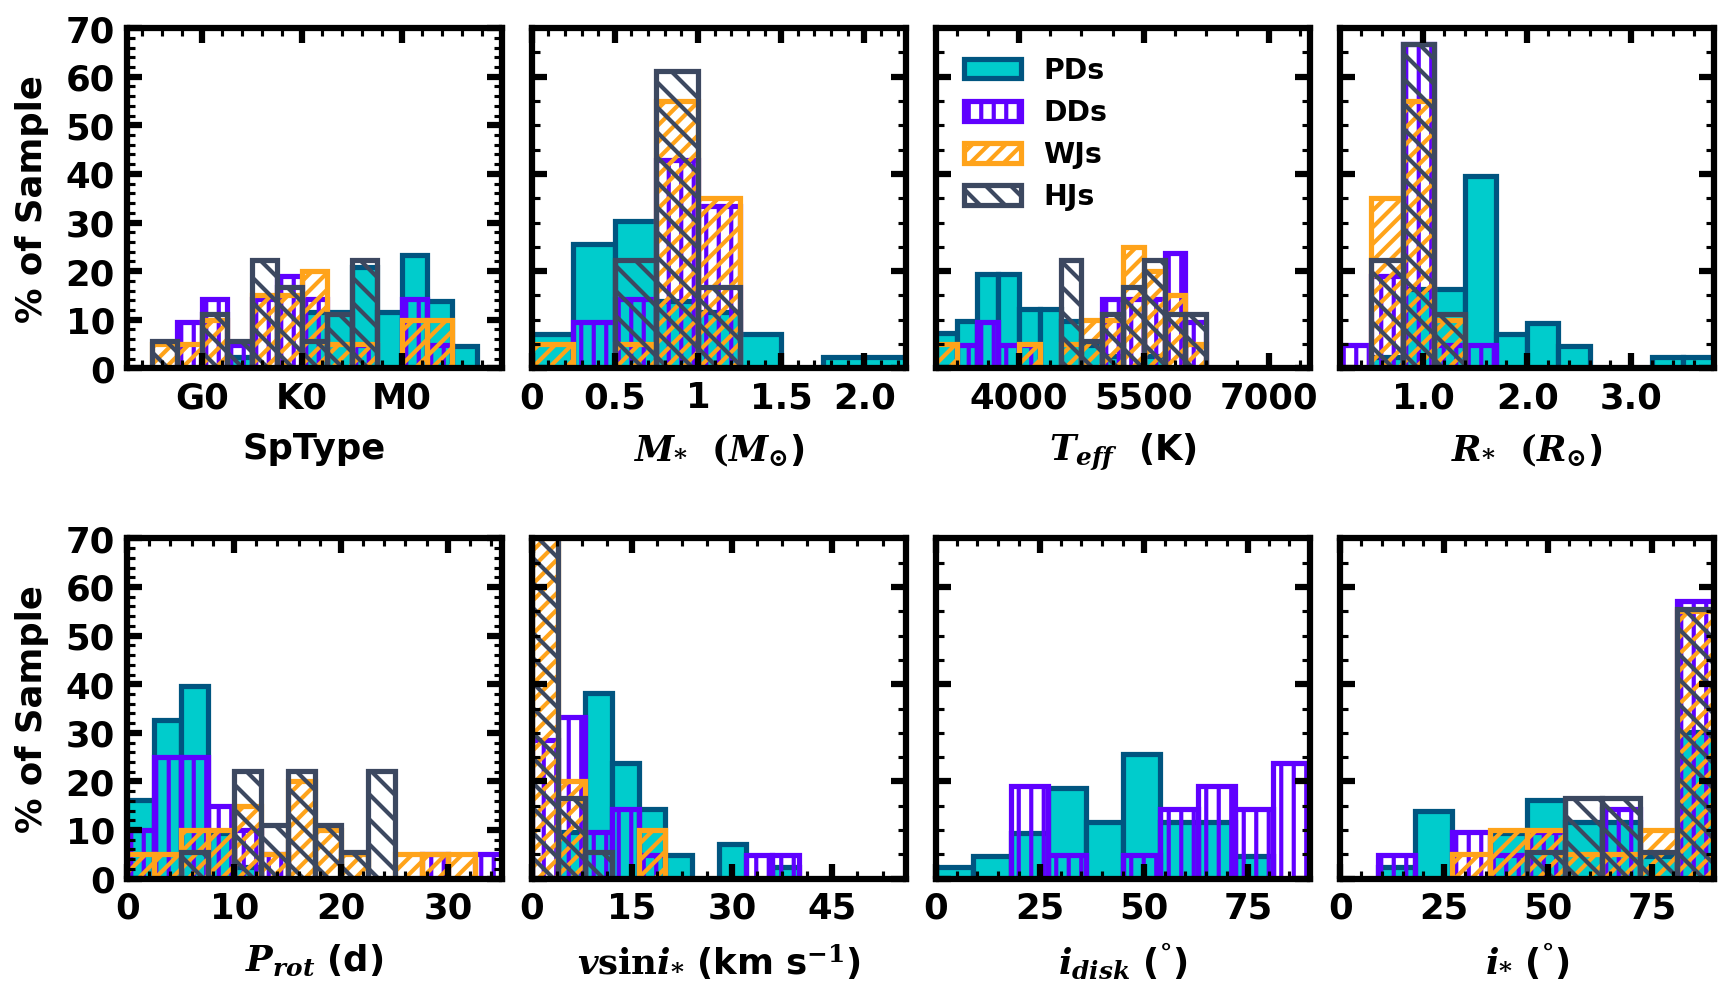

In [13]:
hist_fontsize = 17
hist_title_fontsize = 17
hist_color = '#958bda'  # '#669999'
hist_ylabel = r'% of Sample'
hist_linecolor = '#2f0431'


pd_color = '#00cccc'
pd_linecolor = edge_color
dd_color = '#5f00ff'  # '#6900ff'  #'#8a00e6'  # '#cc0000'
dd_linecolor = '#290066'
WJ_color = '#ffa31a'
WJ_linecolor = '#4d0000'
HJ_color = '#3c4860'  # '#262626'  # '#262626'
HJ_linecolor = '#1d232f'



hists_to_create = {'SpType': {'Title': 'SpType',
                                      'Label': 'SpType',
                                      'Save Text': 'SpType',
                                      'Bin Width': 0.25,
                                      'Bin Range': [2.25, 6.0]  # [3.80, 5.65]
                                      },
                            'Mstar (Msun)': {'Title': 'Stellar Mass',
                                            'Label': r'$M_{*}$  $(M_{\odot}$)',
                                            'Save Text': 'Mstar_distribution_stassun_',
                                            'Bin Width': 0.25,
                                            'Bin Range': [0, 2.25]
                                            },
                            'Teff (K)': {'Title': r'Stellar $T_{eff}$',
                                            'Label': r'$T_{eff}$  (K)',
                                            'Save Text': 'Teff_distribution_stassun_',
                                            'Bin Width': 250,
                                            'Bin Range': [3000, 7500]  # [2750, 5250]
                                            },
                            'Rstar (Rsun)': {'Title': 'Stellar Radius',
                                            'Label': r'$R_{*}$  $(R_{\odot}$)',
                                            'Save Text': 'radii_distribution_stassun_',
                                            'Bin Width': 0.30,
                                            'Bin Range': [0.20, 3.7]  # [0.30, 3.60]
                                            },
                            'Prot (d)': {'Title': 'Rotation Period',
                                        'Label': r'$P_{rot}$ (d)',
                                        'Save Text': 'Prot_distribution_stassun_',
                                        'Bin Width': 2.5,
                                        'Bin Range': [0, 35]
                                        },
                            'vsini (km/s)': {'Title': r'Stellar $v\mathrm{sin}i_{*}$',
                                            'Label': r'$v\mathrm{sin}i_{*}$ (km s$^{-1}$)',
                                            'Save Text': 'vsini_distribution_stassun_',
                                            'Bin Width': 4,
                                            'Bin Range': [0, 55]  # [3, 38]
                                            },
                            'i disk (deg)': {'Title': 'Disk Incl',
                                             'Label': r'$i_{disk}$ ($^\degree$)',
                                             'Save Text': 'iDisk_distribution_stassun_',
                                             'Bin Width': 9,
                                             'Bin Range': [0, 90]
                                             },
                            'i star (deg)': {'Title': 'Stellar Incl',
                                            'Label': r'$i_{*}$ ($^\degree$)',
                                            'Save Text': 'iStar_distribution_stassun_',
                                            'Bin Width': 9,
                                            'Bin Range': [0, 90]
                                            },
                           }

grid_width = 4
grid_height = 2

ymin, ymax = 0, 70  # 14  # 1.15*max(bin_vals)

fig = plt.figure(figsize=(11.5, 7), dpi=150)
gs = gridspec.GridSpec(grid_height , grid_width , width_ratios=[1, 1, 1, 1])
axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height ) for jj in range(grid_width )]
ax_keys = list(hists_to_create.keys())

plot_lit_flag = False

for ax_i, ax in enumerate(axes):

    ax.minorticks_on()

    bin_width = hists_to_create[ax_keys[ax_i]]['Bin Width']
    hist_bins = np.arange(hists_to_create[ax_keys[ax_i]]['Bin Range'][0], hists_to_create[ax_keys[ax_i]]['Bin Range'][1] + bin_width, bin_width)

    bin_vals_biddle, bin_edges = np.histogram(df_biddle[ax_keys[ax_i]].values, bins=hist_bins)
    bin_vals_hurt, bin_edges = np.histogram(df_hurt[ax_keys[ax_i]].values, bins=hist_bins)
    bin_vals_morgan_HJ, bin_edges = np.histogram(df_morgan_HJ[ax_keys[ax_i]].values, bins=hist_bins)
    bin_vals_morgan_WJ, bin_edges = np.histogram(df_morgan_WJ[ax_keys[ax_i]].values, bins=hist_bins)

    bin_vals_percent_biddle = (bin_vals_biddle / sum(bin_vals_biddle))*100
    bin_vals_percent_hurt = (bin_vals_hurt / sum(bin_vals_hurt))*100
    bin_vals_percent_morgan_HJ = (bin_vals_morgan_HJ / sum(bin_vals_morgan_HJ))*100
    bin_vals_percent_morgan_WJ = (bin_vals_morgan_WJ / sum(bin_vals_morgan_WJ))*100

    ax.set_xlabel(hists_to_create[ax_keys[ax_i]]['Label'], fontsize=hist_fontsize, labelpad=8)
    if np.mod(ax_i, grid_width ) == 0:
        ax.set_ylabel(hist_ylabel, fontsize=hist_fontsize, labelpad=8)
        ytick_diff = 10
        ytickvals = [int(ytickval) for ytickval in np.arange(ymin, ymax + ytick_diff, ytick_diff)]
        ax.set_yticks(ytickvals)
        ax.set_yticklabels(ytickvals, fontsize=hist_fontsize)
    else:
        ax.set_yticklabels([])

    mpl.rcParams['hatch.linewidth'] = 2
    
    ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_percent_biddle, edgecolor=pd_linecolor, color=pd_color, lw=2.5, width=bin_width, align='center', label='PDs', alpha=1)
    # ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_percent_hurt, edgecolor=dd_linecolor, color=dd_color, lw=3, width=bin_width, align='center', label='DDs', alpha=0.6)
    ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_percent_hurt, hatch='||', edgecolor=dd_color, color='None', lw=2.5, width=bin_width, align='center', label='DDs', alpha=1)
    if ax_keys[ax_i] != 'i disk (deg)':
        ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_percent_morgan_WJ, hatch='///', edgecolor=WJ_color, color='None', lw=2.5, width=bin_width, align='center', label='WJs', alpha=1)
        ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_percent_morgan_HJ, hatch='\\\\', edgecolor=HJ_color, color='None', lw=2.5, width=bin_width, align='center', label='HJs', alpha=1)
        # ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_percent_morgan_WJ, edgecolor=WJ_linecolor, color=WJ_color, lw=3, width=bin_width, align='center', label='WJs', alpha=0.4)
        # ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_percent_morgan_HJ, edgecolor=HJ_linecolor, color=HJ_color, lw=3, width=bin_width, align='center', label='HJs', alpha=0.4)

        
    if (ax_keys[ax_i] == 'i pp disk (deg)') or (ax_keys[ax_i] == 'i star (deg)'):
        xmin, xmax = 0, 90
    else:
        xmin, xmax = min(hist_bins), max(hist_bins)


    if ax_keys[ax_i] == 'SpType':
        sptype_designations = {'2.25': 'F2.5',
                               '2.50': 'F5',
                               '2.75': 'F7.5',
                               '3.00': 'G0',
                               '3.25': 'G2.5',
                               '3.50': 'G5',
                               '3.75': 'G7.5',
                               '4.00': 'K0',
                               '4.25': 'K2.5',
                               '4.50': 'K5',
                               '4.75': 'K7.5',
                               '5.00': 'M0',
                               '5.25': 'M2.5',
                               '5.50': 'M5',
                               '5.75': 'M7.5',
                               }
        keys_list = list(sptype_designations.keys())
        xtickvals = [float(key) for key in keys_list]
        xticklabs = []
        xticks = []
        for xtick_i, xtick in enumerate(xtickvals):
            if (np.mod(xtick,1) == 0):  #  and (xtick >= xlims[0]):
                xticks.append(xtick)
                xticklabs.append(sptype_designations[keys_list[xtick_i]])
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabs, fontsize=hist_fontsize)

    if ax_keys[ax_i] == 'Mstar (Msun)':
        xtickvals = [0, 0.5, 1, 1.5, 2.0]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if ax_keys[ax_i] == 'Rstar (Rsun)':
        xtickvals = [1.0, 2.0, 3.0]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if ax_keys[ax_i] == 'Prot (d)':
        xtickvals = [0, 10, 20, 30]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if (ax_keys[ax_i] == 'i disk (deg)') or (ax_keys[ax_i] == 'i star (deg)'):
        # xtickvals = [0, 30, 60]
        xtickvals = [0, 25, 50, 75]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)
        

    if ax_keys[ax_i] == 'vsini (km/s)':
        # xtickvals = [0, 15, 30, 45, 60]
        xtickvals = [0, 15, 30, 45]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if ax_keys[ax_i] == 'Teff (K)':
        xtickvals = [4000, 5500, 7000]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

        ax.legend(loc='upper left', prop={'size': 0.8*hist_fontsize}, ncol=1, markerfirst=True)


    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


    ax.tick_params(labelsize=hist_fontsize)

    ax.set_rasterized(True)


fig.subplots_adjust(left=0.07, bottom=0.12, right=0.99, top=0.93, wspace=0.08, hspace=0.50)

save_hist_string = 'Histograms_' + resolution_text + '_' + light_or_dark_dext + '_' + transparent_text + '_' + date_str + '.pdf'

if plot_transparent == True:
    fig.savefig(test_figures_directory + save_hist_string, dpi=300, transparent=True)
else:
    fig.savefig(test_figures_directory + save_hist_string, dpi=300, transparent=False)

plt.show()
plt.close()


In [14]:
df_biddle.columns

Index(['Target', 'SpType', 'SpType Unc', 'SpType Letter', 'SpType Letter Unc',
       'Teff (K)', 'Teff Unc', 'Mstar (Msun)', 'Mstar Unc', 'Rstar (Rsun)',
       'Rstar Unc', 'Prot (d)', 'Prot Unc', 'vsini (km/s)', 'vsini Unc',
       'i disk (deg)', 'i disk Unc', 'i star (deg)', 'i star +Unc',
       'i star -Unc', 'disk diff', 'disk diff +Unc', 'disk diff -Unc', 'Veq',
       'Veq Unc'],
      dtype='object')

In [15]:
# biddle_kde_df = pd.read_csv('/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Tables/Condensed_Sample_By_Date/KDE_highRes_2024-May-22.csv')
# # biddle_kde_df.columns

# density_estimation_total_positive_x_biddle = np.array(biddle_kde_df['density_estimation_total'].values)
# x_grid_plot_biddle = biddle_kde_df['all_posterior_i_values'].values
# density_estimation_total_positive_x_biddle = density_estimation_total_positive_x_biddle[x_grid_plot_biddle >= 0]
# x_grid_plot_biddle = x_grid_plot_biddle[x_grid_plot_biddle >= 0]
# print(np.diff(x_grid_plot_biddle)[0])

### Monte Carlo Distributions

In [129]:
def montecarlo_distributions(df, which_list, resolution, n_parameter_draws, test_object, save_csv=True, do_test_object_only=False, do_limit_target_list=False):

    np.random.seed(42)

    if do_limit_target_list == True:
        target_list = df['Target'].values[0:4]
    else:
        target_list = df['Target'].values

    if resolution == 'high':
        n_draws = int(5e6)
        sampling_res = 0.01
        smooth_over_deg = 0.5
    elif resolution == 'med':
        n_draws = int(1e6)
        sampling_res = 0.5
        smooth_over_deg = 3
    else:
        n_draws = int(1e4)
        sampling_res = 1.0
        smooth_over_deg = 5
    
    istars = np.arange(0, 90+sampling_res, sampling_res)
    i_bins = np.concatenate((istars, np.array([istars[-1] + sampling_res])))

    distributions_dict = {}
    for _, target in enumerate(target_list):

        Deltai_dict = {}

        if (do_test_object_only == True) and (target == test_object):

            print('~~~~~~~~~~~~~~~~~~~~~~ ' + which_list + ' ~~~~~~~~~~~~~~~~~~~~~~')
            print(target)

            targ_df = df[df['Target'] == target]

            nominal_vsini = targ_df['vsini (km/s)'].values[0]
            sigma_vsini = targ_df['vsini Unc'].values[0]

            nominal_Prot = (targ_df['Prot (d)'].values[0] * u.d).to(u.s).value
            sigma_Prot = (targ_df['Prot Unc'].values[0] * u.d).to(u.s).value
            
            nominal_Rstar = (targ_df['Rstar (Rsun)'].values[0] * u.Rsun).to(u.km).value
            sigma_Rstar = (targ_df['Rstar Unc'].values[0] * u.Rsun).to(u.km).value

            nominal_idisk = targ_df['i disk (deg)'].values[0]
            sigma_idisk = targ_df['i disk Unc'].values[0]

            distributions_dict[target] = {}

            istar_distributions = []
            idisk_distributions = []
            Deltai_distributions = []

            # ------------------------------------------------------------------------------------- #
            # ---------------------- COMPUTE i STAR PROBABILITY DISTRIBUTION ---------------------- #
            # ------------------------------------------------------------------------------------- #

            vsini_list = []
            for draw in range(n_parameter_draws):
                vsini_draw = np.random.normal(nominal_vsini, sigma_vsini, 1)[0]
                while vsini_draw <= 0:
                    vsini_draw = np.random.normal(nominal_vsini, sigma_vsini, 1)[0]
                vsini_list.append(vsini_draw)
            vsini_list.append(nominal_vsini)

            Prot_list = []
            for draw in range(n_parameter_draws):
                Prot_draw = np.random.normal(nominal_Prot, sigma_Prot, 1)[0]
                while Prot_draw <= 0:
                    Prot_draw = np.random.normal(nominal_Prot, sigma_Prot, 1)[0]
                Prot_list.append(Prot_draw)
            Prot_list.append(nominal_Prot)

            Rstar_list = []
            for draw in range(n_parameter_draws):
                Rstar_draw = np.random.normal(nominal_Rstar, sigma_Rstar, 1)[0]
                while Rstar_draw <= 0:
                    Rstar_draw = np.random.normal(nominal_Rstar, sigma_Rstar, 1)[0]
                Rstar_list.append(Rstar_draw)
            Rstar_list.append(nominal_Rstar)

            for draw in range(len(vsini_list)):
                vsini = vsini_list[draw]
                Prot = Prot_list[draw]
                Rstar = Rstar_list[draw]

                # print(vsini, Prot, Rstar)


                veq = (2 * np.pi * Rstar)/(Prot)
                sigma_veq = veq * np.sqrt((sigma_Rstar/Rstar)**2 + (sigma_Prot/Prot)**2)

                sini = np.sin(np.radians(istars))

                if sigma_vsini != 'ulimit':
                    part1 = vsini - veq * sini
                    part2 = 2 * (sigma_vsini**2 + sigma_veq**2 * sini**2)
                    i_star_dist = sini * (np.exp(-(part1**2)/part2))/np.sqrt(part2)
                else:
                    i_star_dist_list = []
                    for sini_element in range(len(sini)):
                        part1 = vsini - veq * sini[sini_element]
                        part2 = np.sqrt(2) * sigma_veq * sini[sini_element]
                        part3 = np.sqrt(2) * np.pi * Rstar
                        part4 = sigma_veq * Prot
                        istar_element = sini[sini_element] * (erf(part1/part2) + erf(part3/part4))
                        i_star_dist_list.append(istar_element)
                    i_star_dist = np.array(i_star_dist_list)

                istars = istars[np.isnan(i_star_dist) == False]
                i_star_dist = i_star_dist[np.isnan(i_star_dist) == False]

                i_star_dist = i_star_dist / (sum(i_star_dist) * sampling_res)

                istar_distributions.append(i_star_dist)

            distributions_dict[target]['istar'] = istar_distributions




            # ------------------------------------------------------------------------------------- #
            # ---------------------- COMPUTE i DISK PROBABILITY DISTRIBUTION ---------------------- #
            # ------------------------------------------------------------------------------------- #

            idisk_list = []
            for draw in range(n_parameter_draws):
                idisk_draw = np.random.normal(nominal_idisk, sigma_idisk, 1)[0]
                while idisk_draw <= 0:
                    idisk_draw = np.random.normal(nominal_idisk, sigma_idisk, 1)[0]
                idisk_list.append(idisk_draw)
            idisk_list.append(nominal_idisk)

            for draw in range(len(idisk_list)):
                idisk = idisk_list[draw]
                i_disk_dist = norm.pdf(x=istars, loc=idisk, scale=sigma_idisk)

                idisk_distributions.append(i_disk_dist)

            distributions_dict[target]['idisk'] = idisk_distributions





            # ------------------------------------------------------------------------------------- #
            # --------------------- COMPUTE DELTA i PROBABILITY DISTRIBUTION ---------------------- #
            # ------------------------------------------------------------------------------------- #

            for draw in range(len(vsini_list)):
                # clear_output(wait=True)
                print(r"Deltai's:  " + '{:.2f}%'.format(((draw + 1)/len(vsini_list))*100), end="\r")
                i_star_rand = choices(istars, istar_distributions[draw], k=n_draws)
                i_disk_rand = choices(istars, idisk_distributions[draw], k=n_draws)
                Deltai_rand = abs(np.array(i_disk_rand) - i_star_rand)

                bin_vals_Deltai, _ = np.histogram(Deltai_rand, bins=i_bins)

                smooth_over_deltai= smooth_over_deg/sampling_res
                smooth_vals_Deltai = gaussian_filter1d(bin_vals_Deltai, smooth_over_deltai)

                smooth_on = True
                if smooth_on == True:
                    Deltai_dist = smooth_vals_Deltai / (sum(smooth_vals_Deltai) * sampling_res)
                else:
                    Deltai_dist = bin_vals_Deltai / (sum(bin_vals_Deltai) * sampling_res)

                Deltai_distributions.append(Deltai_dist)

                Deltai_dict[str(draw)] = Deltai_dist

            if save_csv == True:
                Deltai_df = pd.DataFrame(Deltai_dict)
                Deltai_df.to_csv(tables_dictionary + 'MonteCarlo_Deltai/' + target.replace(' ', '') + '_MC_Deltai.csv', index=False)
            
            distributions_dict[target]['Deltai'] = Deltai_distributions


        else:
            print('~~~~~~~~~~~~~~~~~~~~~~ ' + which_list + ' ~~~~~~~~~~~~~~~~~~~~~~')
            print(target)

            targ_df = df[df['Target'] == target]

            nominal_vsini = targ_df['vsini (km/s)'].values[0]
            sigma_vsini = targ_df['vsini Unc'].values[0]

            nominal_Prot = (targ_df['Prot (d)'].values[0] * u.d).to(u.s).value
            sigma_Prot = (targ_df['Prot Unc'].values[0] * u.d).to(u.s).value
            
            nominal_Rstar = (targ_df['Rstar (Rsun)'].values[0] * u.Rsun).to(u.km).value
            sigma_Rstar = (targ_df['Rstar Unc'].values[0] * u.Rsun).to(u.km).value

            nominal_idisk = targ_df['i disk (deg)'].values[0]
            sigma_idisk = targ_df['i disk Unc'].values[0]

            distributions_dict[target] = {}

            istar_distributions = []
            idisk_distributions = []
            Deltai_distributions = []

            # ------------------------------------------------------------------------------------- #
            # ---------------------- COMPUTE i STAR PROBABILITY DISTRIBUTION ---------------------- #
            # ------------------------------------------------------------------------------------- #

            vsini_list = []
            for draw in range(n_parameter_draws):
                vsini_draw = np.random.normal(nominal_vsini, sigma_vsini, 1)[0]
                while vsini_draw <= 0:
                    vsini_draw = np.random.normal(nominal_vsini, sigma_vsini, 1)[0]
                vsini_list.append(vsini_draw)
            vsini_list.append(nominal_vsini)

            Prot_list = []
            for draw in range(n_parameter_draws):
                Prot_draw = np.random.normal(nominal_Prot, sigma_Prot, 1)[0]
                while Prot_draw <= 0:
                    Prot_draw = np.random.normal(nominal_Prot, sigma_Prot, 1)[0]
                Prot_list.append(Prot_draw)
            Prot_list.append(nominal_Prot)

            Rstar_list = []
            for draw in range(n_parameter_draws):
                Rstar_draw = np.random.normal(nominal_Rstar, sigma_Rstar, 1)[0]
                while Rstar_draw <= 0:
                    Rstar_draw = np.random.normal(nominal_Rstar, sigma_Rstar, 1)[0]
                Rstar_list.append(Rstar_draw)
            Rstar_list.append(nominal_Rstar)

            for draw in range(len(vsini_list)):
                vsini = vsini_list[draw]
                Prot = Prot_list[draw]
                Rstar = Rstar_list[draw]

                # print(vsini, Prot, Rstar)


                veq = (2 * np.pi * Rstar)/(Prot)
                sigma_veq = veq * np.sqrt((sigma_Rstar/Rstar)**2 + (sigma_Prot/Prot)**2)

                sini = np.sin(np.radians(istars))

                if sigma_vsini != 'ulimit':
                    part1 = vsini - veq * sini
                    part2 = 2 * (sigma_vsini**2 + sigma_veq**2 * sini**2)
                    i_star_dist = sini * (np.exp(-(part1**2)/part2))/np.sqrt(part2)
                else:
                    i_star_dist_list = []
                    for sini_element in range(len(sini)):
                        part1 = vsini - veq * sini[sini_element]
                        part2 = np.sqrt(2) * sigma_veq * sini[sini_element]
                        part3 = np.sqrt(2) * np.pi * Rstar
                        part4 = sigma_veq * Prot
                        istar_element = sini[sini_element] * (erf(part1/part2) + erf(part3/part4))
                        i_star_dist_list.append(istar_element)
                    i_star_dist = np.array(i_star_dist_list)

                istars = istars[np.isnan(i_star_dist) == False]
                i_star_dist = i_star_dist[np.isnan(i_star_dist) == False]

                i_star_dist = i_star_dist / (sum(i_star_dist) * sampling_res)

                istar_distributions.append(i_star_dist)

            distributions_dict[target]['istar'] = istar_distributions




            # ------------------------------------------------------------------------------------- #
            # ---------------------- COMPUTE i DISK PROBABILITY DISTRIBUTION ---------------------- #
            # ------------------------------------------------------------------------------------- #

            idisk_list = []
            for draw in range(n_parameter_draws):
                idisk_draw = np.random.normal(nominal_idisk, sigma_idisk, 1)[0]
                while idisk_draw <= 0:
                    idisk_draw = np.random.normal(nominal_idisk, sigma_idisk, 1)[0]
                idisk_list.append(idisk_draw)
            idisk_list.append(nominal_idisk)

            for draw in range(len(idisk_list)):
                idisk = idisk_list[draw]
                i_disk_dist = norm.pdf(x=istars, loc=idisk, scale=sigma_idisk)

                idisk_distributions.append(i_disk_dist)

            distributions_dict[target]['idisk'] = idisk_distributions





            # ------------------------------------------------------------------------------------- #
            # --------------------- COMPUTE DELTA i PROBABILITY DISTRIBUTION ---------------------- #
            # ------------------------------------------------------------------------------------- #

            for draw in range(len(vsini_list)):
                # clear_output(wait=True)
                print(r"Deltai's:  " + '{:.2f}%'.format(((draw + 1)/len(vsini_list))*100), end="\r")
                i_star_rand = choices(istars, istar_distributions[draw], k=n_draws)
                i_disk_rand = choices(istars, idisk_distributions[draw], k=n_draws)
                Deltai_rand = abs(np.array(i_disk_rand) - i_star_rand)

                bin_vals_Deltai, _ = np.histogram(Deltai_rand, bins=i_bins)

                smooth_over_deltai= smooth_over_deg/sampling_res
                smooth_vals_Deltai = gaussian_filter1d(bin_vals_Deltai, smooth_over_deltai)

                smooth_on = True
                if smooth_on == True:
                    Deltai_dist = smooth_vals_Deltai / (sum(smooth_vals_Deltai) * sampling_res)
                else:
                    Deltai_dist = bin_vals_Deltai / (sum(bin_vals_Deltai) * sampling_res)

                Deltai_distributions.append(Deltai_dist)

                Deltai_dict[str(draw)] = Deltai_dist

            if save_csv == True:
                Deltai_df = pd.DataFrame(Deltai_dict)
                Deltai_df.to_csv(tables_dictionary + 'MonteCarlo_Deltai/' + target.replace(' ', '') + '_MC_Deltai.csv', index=False)

            distributions_dict[target]['Deltai'] = Deltai_distributions


    return distributions_dict


In [130]:
do_kde_montecarlo_test = True
if do_kde_montecarlo_test == True:
    test_targ = 'CX Tau'
    n_par_draws = 10
    distributions_biddle = montecarlo_distributions(df=df_biddle, which_list='biddle', resolution=sampling_resolution,
                                                    n_parameter_draws=n_par_draws, test_object=test_targ,
                                                    save_csv=True, do_test_object_only=False, do_limit_target_list=True)


~~~~~~~~~~~~~~~~~~~~~~ biddle ~~~~~~~~~~~~~~~~~~~~~~
2MASS J04124068+2438157


OSError: Cannot save file into a non-existent directory: '/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/MonteCarlo_Deltai'

In [84]:
distributions_biddle.keys()

dict_keys(['2MASS J04124068+2438157', '2MASS J04155799+2746175', '2MASS J04202555+2700355', '2MASS J04322210+1827426'])

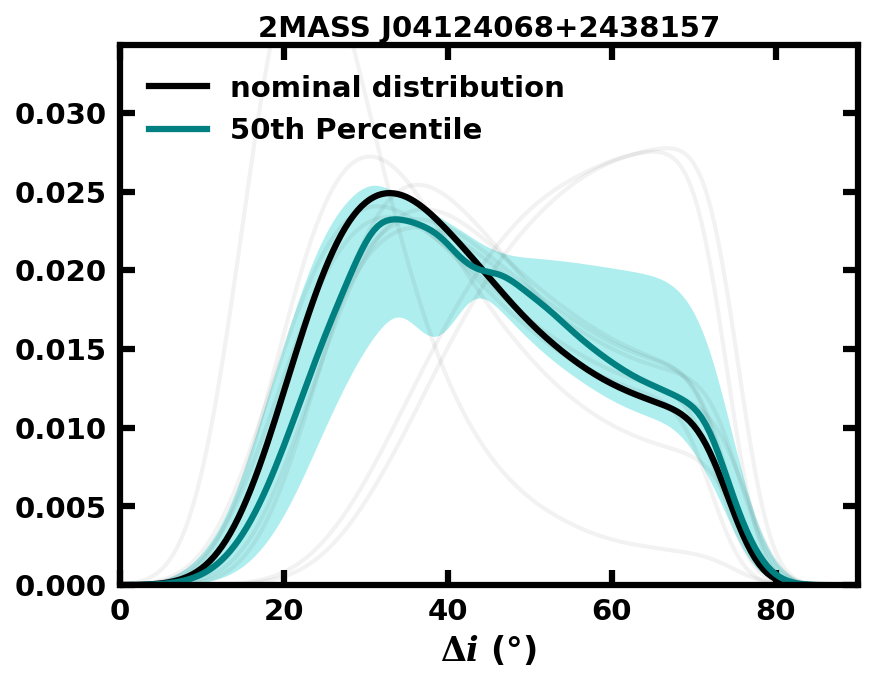

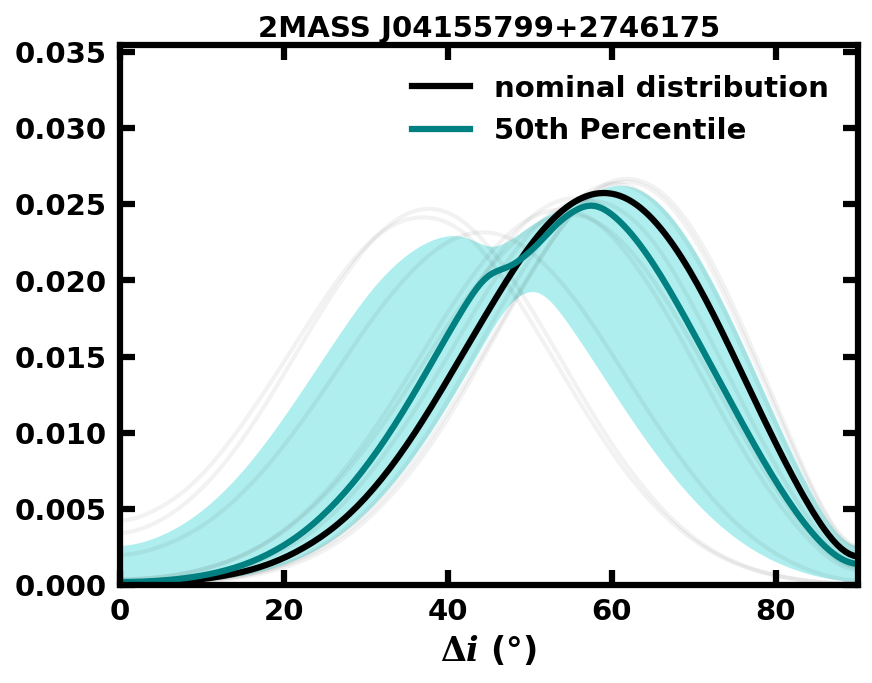

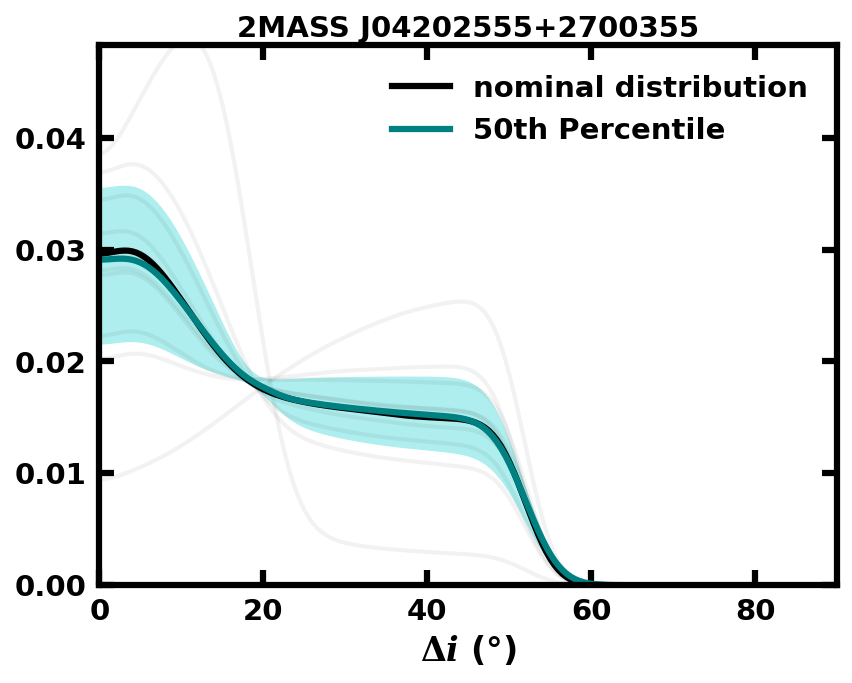

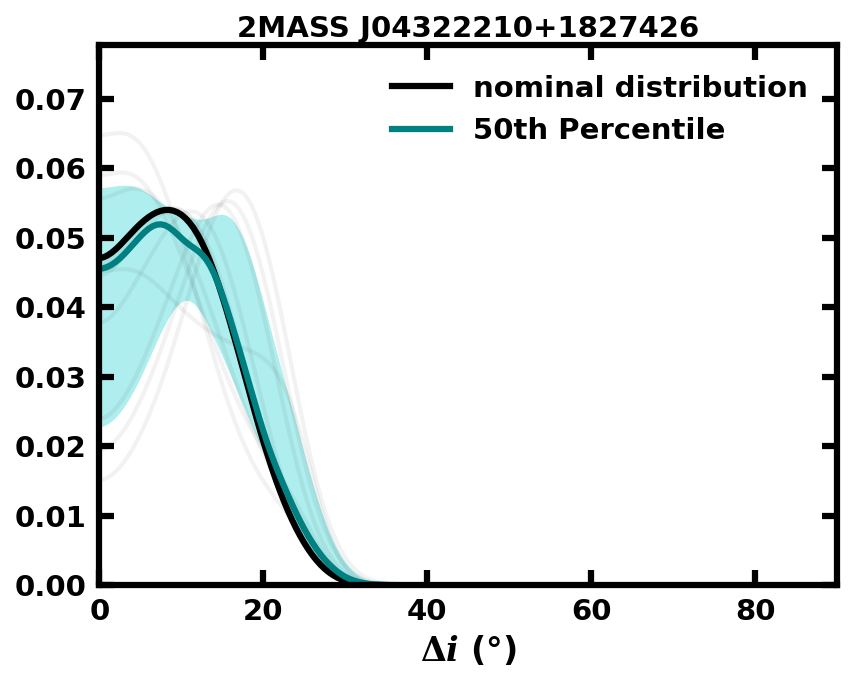

In [127]:
if do_kde_montecarlo_test == True:

    test_distribution = 'Deltai'
    
    for target in distributions_biddle.keys():

        test_list = distributions_biddle[target][test_distribution]
        test_list_transposed = np.transpose(test_list)

        # ------------------ DETERMINE X_GRID ------------------ #
        Posteriors = pd.read_csv(probability_distributions_dir+ 'Posteriors_'+ target.replace(' ', '') + '_biddle.csv')
        posterior_i_values = Posteriors['i (deg)'].values
        dx_test = np.diff(posterior_i_values)[0]

        if test_distribution == 'istar':
            posterior_values = np.array(Posteriors['P(i Star | d)'].values)
            xlab = r'$i_{\ast}$ ($\degree$)'
        elif test_distribution == 'idisk':
            posterior_values = np.array(Posteriors['P(i Disk | d)'].values)
            xlab = r'$i_{\textrm{disk}}$ ($\degree$)'
        elif test_distribution == 'Deltai':
            posterior_values = np.array(Posteriors['P(Delta i | d)'].values)
            xlab = r'$\Delta i$ ($\degree$)'

        mean_draws = []
        stddev_draws = []
        percentile_16 = []
        percentile_50 = []
        percentile_84 = []

        for element_i in range(len(test_list_transposed)):
            mean_draws.append(np.mean(test_list_transposed[element_i]))
            stddev_draws.append(np.std(test_list_transposed[element_i], ddof=1))
            percentile_16.append(np.percentile(test_list_transposed[element_i], 16))
            percentile_50.append(np.percentile(test_list_transposed[element_i], 50))
            percentile_84.append(np.percentile(test_list_transposed[element_i], 84))

        mean_draws = np.array(mean_draws)
        stddev_draws = np.array(stddev_draws)
        percentile_16 = np.array(percentile_16)
        percentile_50 = np.array(percentile_50)
        percentile_84 = np.array(percentile_84)

        if test_distribution == 'Deltai':
            sigma_smooth = 6*dx_test
            mean_draws = gaussian_filter1d(mean_draws, sigma_smooth)
            stddev_draws  = gaussian_filter1d(stddev_draws, sigma_smooth)
            percentile_16 = gaussian_filter1d(percentile_16, sigma_smooth)
            percentile_50  = gaussian_filter1d(percentile_50, sigma_smooth)
            percentile_84 = gaussian_filter1d(percentile_84, sigma_smooth)

        do_percentiles = True
        if do_percentiles == False:
            lower_curve = mean_draws - stddev_draws
            middle_curve = mean_draws
            upper_curve = mean_draws + stddev_draws
        else:
            lower_curve = percentile_16
            middle_curve = percentile_50
            upper_curve = percentile_84


        # if test_distribution == 'Deltai':
        #     lower_draws = lower_curve / (sum(mean_draws) * dx_test)
        #     upper_draws = upper_curve / (sum(mean_draws) * dx_test)
        #     mean_draws = mean_draws / (sum(mean_draws) * dx_test)

        xmin_test, xmax_test = 0, 90
        ymin_test, ymax_test = 0, 1.35 * max(upper_curve)

        fig = plt.figure(figsize=(6,4.5), dpi=150)
        ax = fig.add_subplot(111)
        for element_i in range(len(test_list)):
            ax.plot(posterior_i_values, test_list[element_i], color='#000000', lw=2, alpha=0.05, zorder=-4)
        ax.plot(posterior_i_values, posterior_values, color='#000000', lw=3, alpha=1, label='nominal distribution', zorder=-3)
        if do_percentiles == False:
            ax.plot(posterior_i_values, middle_curve, color='teal', lw=3, label='mean distribution', zorder=-2)
        else:
            ax.plot(posterior_i_values, middle_curve, color='teal', lw=3, label='50th Percentile')
        ax.fill_between(posterior_i_values, upper_curve, lower_curve, lw=0, color='paleturquoise', alpha=1, zorder=-5)
        ax.set_xlim(xmin_test, xmax_test)
        ax.set_ylim(ymin_test, ymax_test)
        ax.set_title(target)
        ax.set_xlabel(xlab, fontsize=16)
        ax.legend(loc='best', ncol=1)

        fig.subplots_adjust(left=0.16, bottom=0.14, right=0.98, top=0.94, wspace=0.08, hspace=0.50)

        fig.savefig(test_figures_directory + 'MonteCarlo_Deltai/' + target.replace(' ', '') + '_MC_Deltai.pdf', dpi=300)
        plt.show() 



In [93]:
def draw_data_for_kde(distributions, prob_i, posterior_i_values, kde_n_draws):

    # ------------------ GENERATE ARRAY OF DRAWS FROM ALL PROBABILITY DISTRIBUTIONS ------------------ #

    data_for_kde = []
    
    for targetnum in range(len(list(distributions_biddle.keys()))):

        target = list(distributions_biddle.keys())[targetnum]

        Deltai_distributions = distributions[target]['Deltai']

        P_Delta_i_target = np.array(Deltai_distributions[prob_i])

        data_for_kde.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))

    data_for_kde = np.array(data_for_kde).reshape(-1, 1)

    return data_for_kde

def generate_kde(data_for_kde, posterior_i_values, dx, kde_bandwidth):

    reverse_posterior_i_values = -posterior_i_values[::-1][:-1]
    all_posterior_i_values = np.concatenate((np.array(reverse_posterior_i_values), np.array(posterior_i_values)))
    x_grid_all = np.array(all_posterior_i_values).reshape(-1, 1)

    kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth).fit(data_for_kde)
    log_density = kde.score_samples(x_grid_all)

    density_estimation = np.array(np.exp(log_density))

    density_estimation_mirrored = density_estimation[::-1]

    density_estimation_total = density_estimation + density_estimation_mirrored

    density_estimation_total_positive_x = density_estimation_total[all_posterior_i_values >= 0]

    smooth_on = False
    if smooth_on == True:
        smooth_over_deg = 1
        print('smooth over: ', smooth_over_deg, 'deg')
        smooth_over_points = int(smooth_over_deg/dx)
        if np.mod(smooth_over_points, 2) != 0:
            smooth_over_points += 1

        smooth_vals_i_diff = gaussian_filter1d(density_estimation_total_positive_x, smooth_over_points) 

        density_estimation_total_positive_x = smooth_vals_i_diff / (sum(smooth_vals_i_diff) * dx)
    else:
        density_estimation_total_positive_x = density_estimation_total_positive_x / (sum(density_estimation_total_positive_x) * dx)
    
    return density_estimation_total_positive_x



In [120]:

Posteriors = pd.read_csv(probability_distributions_dir+ 'Posteriors_tauCeti_hurt.csv')
x_grid_plot = Posteriors['i (deg)'].values
dx = np.diff(x_grid_plot)[0]

kde_n_draws = 50  # int(1e2)  # int(5e3)
kde_bandwidth = 5
which_dataset = 'biddle'

kdes = []

print('dx: ', dx, '\n')
print('KDE Bandwidth ' + which_dataset + ' = ', kde_bandwidth)

for prob_i in range(n_par_draws):
    data_for_kde_biddle_i = draw_data_for_kde(distributions=distributions_biddle, prob_i=prob_i, posterior_i_values=x_grid_plot, kde_n_draws=kde_n_draws)
    density_estimation_biddle_i = generate_kde(data_for_kde=data_for_kde_biddle_i, posterior_i_values=x_grid_plot, dx=dx, kde_bandwidth=kde_bandwidth)
    kdes.append(density_estimation_biddle_i)

nominal_data_for_kde_biddle = draw_data_for_kde(distributions=distributions_biddle, prob_i=-1, posterior_i_values=x_grid_plot, kde_n_draws=kde_n_draws)
nominal_density_estimation_biddle = generate_kde(data_for_kde=nominal_data_for_kde_biddle, posterior_i_values=x_grid_plot, dx=dx, kde_bandwidth=kde_bandwidth)

kde_16 = np.percentile(kdes, 16, axis=0)
kde_50 = np.percentile(kdes, 50, axis=0)
kde_84 = np.percentile(kdes, 84, axis=0)

kde_16 = gaussian_filter1d(kde_16, sigma_smooth)
kde_50 = gaussian_filter1d(kde_50, sigma_smooth)
kde_84 = gaussian_filter1d(kde_84, sigma_smooth)

KDE_filepath = save_csv_filepath_biddle  + 'KDE_' + resolution_text + '_'+ date_str + '.csv'




dx:  0.5 

KDE Bandwidth biddle =  5


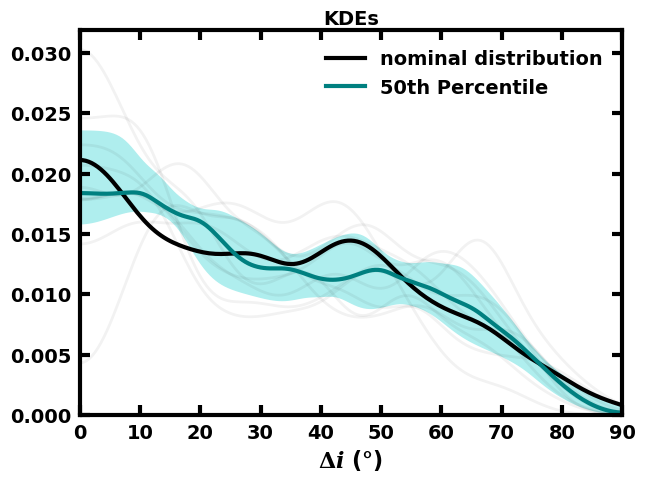

In [121]:
xmin_test, xmax_test = 0, 90
ymin_test, ymax_test = 0, 1.35 * max(kde_84)

for kde_i in range(len(kdes)):
    plt.plot(x_grid_plot, kdes[kde_i], color='#000000', lw=2, alpha=0.05, zorder=-4)
plt.plot(x_grid_plot, nominal_density_estimation_biddle, color='#000000', lw=3, alpha=1, label='nominal distribution', zorder=-3)
plt.plot(x_grid_plot, kde_50, color='teal', lw=3, label='50th Percentile')
plt.fill_between(x_grid_plot, kde_84, kde_16, lw=0, color='paleturquoise', alpha=1, zorder=-5)
plt.xlim(xmin_test, xmax_test)
plt.ylim(ymin_test, ymax_test)
plt.title('KDEs')
plt.xlabel(r'$\Delta i$ ($\degree$)', fontsize=16)
plt.legend(loc='best', ncol=1)
plt.show() 

In [ ]:
    # density_estimations = {'x_grid_plot': x_grid_plot,
    #                        'dx': dx,
    #                        'biddle': density_estimation_total_positive_x_biddle,
    #                        'hurt': density_estimation_total_positive_x_hurt,
    #                        'hurt': density_estimation_total_positive_x_morgan_WJ,
    #                        'hurt': density_estimation_total_positive_x_morgan_HJ,
    #                        }

### Next

In [76]:
# ------------------ DETERMINE X_GRID ------------------ #
Posteriors = pd.read_csv(probability_distributions_dir+ 'Posteriors_tauCeti_hurt.csv')
posterior_i_values = Posteriors['i (deg)'].values
x_grid = np.array(posterior_i_values).reshape(-1, 1)

reverse_posterior_i_values = -posterior_i_values[::-1][:-1]
all_posterior_i_values = np.concatenate((np.array(reverse_posterior_i_values), np.array(posterior_i_values)))
x_grid_all = np.array(all_posterior_i_values).reshape(-1, 1)

x_grid_plot = np.copy(posterior_i_values)



KDE_filepath = save_csv_filepath_biddle  + 'KDE_' + resolution_text + '_'+ date_str + '.csv'


do_mirror = True

track_posteriors = []

kde_n_draws = int(5e3)
# kde_n_draws = int(1e5)

data_for_kde_biddle = []
data_for_kde_hurt = []
data_for_kde_morgan_WJ = []
data_for_kde_morgan_HJ = []

# ------------------ COMPUTE KDE FROM DRAWS ------------------ #

# --------------------------- BIDDLE-------------------------- #
band_width_biddle = 5
print('KDE Bandwidth biddle = ', band_width_biddle)
for targetnum in range(len(df_biddle['Target'].values)):

    target_str = df_biddle['Target'].values[targetnum].replace(' ', '')
    if '/' in df_biddle['Target'].values[targetnum]:
        target_str = target_str.replace('/', '-')

    Posteriors = pd.read_csv(probability_distributions_dir + 'Posteriors_' + target_str + '_biddle.csv')
    P_Delta_i_target = np.array(Posteriors['P(Delta i | d)'].values)

    track_posteriors.append(P_Delta_i_target)

    data_for_kde_biddle.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))

# --------------------------- HURT --------------------------- #
band_width_hurt = 5
print('KDE Bandwidth hurt = ', band_width_hurt)
for targetnum in range(len(df_hurt['Target'].values)):

    target_str = df_hurt['Target'].values[targetnum].replace(' ', '')
    if '/' in df_hurt['Target'].values[targetnum]:
        target_str = target_str.replace('/', '-')

    Posteriors = pd.read_csv(probability_distributions_dir + 'Posteriors_' + target_str + '_hurt.csv')
    P_Delta_i_target = np.array(Posteriors['P(Delta i | d)'].values)

    track_posteriors.append(P_Delta_i_target)

    data_for_kde_hurt.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))


# ------------------------- MORGAN WJ ------------------------ #
band_width_morgan_WJ = 5
print('KDE Bandwidth morgan WJ = ', band_width_morgan_WJ)
for targetnum in range(len(df_morgan_WJ['Target'].values)):

    target_str = df_morgan_WJ['Target'].values[targetnum].replace(' ', '')
    if '/' in df_morgan_WJ['Target'].values[targetnum]:
        target_str = target_str.replace('/', '-')

    Posteriors = pd.read_csv(probability_distributions_dir + 'Posteriors_' + target_str + '_morgan_WJ.csv')
    P_Delta_i_target = np.array(Posteriors['P(Delta i | d)'].values)

    track_posteriors.append(P_Delta_i_target)

    data_for_kde_morgan_WJ.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))


# ------------------------- MORGAN HJ ------------------------ #
band_width_morgan_HJ = 5
print('KDE Bandwidth morgan HJ = ', band_width_morgan_HJ)
for targetnum in range(len(df_morgan_HJ['Target'].values)):

    target_str = df_morgan_HJ['Target'].values[targetnum].replace(' ', '')
    if '/' in df_morgan_HJ['Target'].values[targetnum]:
        target_str = target_str.replace('/', '-')

    Posteriors = pd.read_csv(probability_distributions_dir + 'Posteriors_' + target_str + '_morgan_HJ.csv')
    P_Delta_i_target = np.array(Posteriors['P(Delta i | d)'].values)

    track_posteriors.append(P_Delta_i_target)

    data_for_kde_morgan_HJ.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))

    



data_for_kde_biddle = np.array(data_for_kde_biddle).reshape(-1, 1)
data_for_kde_hurt = np.array(data_for_kde_hurt).reshape(-1, 1)
data_for_kde_morgan_HJ = np.array(data_for_kde_morgan_HJ).reshape(-1, 1)
data_for_kde_morgan_WJ = np.array(data_for_kde_morgan_WJ).reshape(-1, 1)

kde_biddle = KernelDensity(kernel='gaussian', bandwidth=band_width_biddle).fit(data_for_kde_biddle)
kde_hurt = KernelDensity(kernel='gaussian', bandwidth=band_width_hurt).fit(data_for_kde_hurt)
kde_morgan_WJ = KernelDensity(kernel='gaussian', bandwidth=band_width_morgan_WJ).fit(data_for_kde_morgan_WJ)
kde_morgan_HJ = KernelDensity(kernel='gaussian', bandwidth=band_width_morgan_HJ).fit(data_for_kde_morgan_HJ)

log_density_biddle = kde_biddle.score_samples(x_grid_all)
log_density_hurt = kde_hurt.score_samples(x_grid_all)
log_density_morgan_WJ = kde_morgan_WJ.score_samples(x_grid_all)
log_density_morgan_HJ = kde_morgan_HJ.score_samples(x_grid_all)

density_estimation_biddle = np.array(np.exp(log_density_biddle))
density_estimation_hurt = np.array(np.exp(log_density_hurt))
density_estimation_morgan_WJ = np.array(np.exp(log_density_morgan_WJ))
density_estimation_morgan_HJ = np.array(np.exp(log_density_morgan_HJ))

density_estimation_mirrored_biddle = density_estimation_biddle[::-1]
density_estimation_mirrored_hurt = density_estimation_hurt[::-1]
density_estimation_mirrored_morgan_WJ = density_estimation_morgan_WJ[::-1]
density_estimation_mirrored_morgan_HJ = density_estimation_morgan_HJ[::-1]

density_estimation_total_biddle = density_estimation_biddle + density_estimation_mirrored_biddle
density_estimation_total_hurt = density_estimation_hurt + density_estimation_mirrored_hurt
density_estimation_total_morgan_WJ = density_estimation_morgan_WJ + density_estimation_mirrored_morgan_WJ
density_estimation_total_morgan_HJ = density_estimation_morgan_HJ + density_estimation_mirrored_morgan_HJ

KDE_dict = {'all_posterior_i_values': all_posterior_i_values,
            'density_estimation_biddle': density_estimation_biddle,
            'density_estimation_hurt': density_estimation_hurt,
            'density_estimation_morgan_WJ': density_estimation_morgan_WJ,
            'density_estimation_morgan_HJ': density_estimation_morgan_HJ,
            'density_estimation_mirrored_biddle': density_estimation_mirrored_biddle,
            'density_estimation_mirrored_hurt': density_estimation_mirrored_hurt,
            'density_estimation_mirrored_morgan_WJ': density_estimation_mirrored_morgan_WJ,
            'density_estimation_mirrored_morgan_HJ': density_estimation_mirrored_morgan_HJ,
            'density_estimation_total_biddle': density_estimation_total_biddle,
            'density_estimation_total_hurt': density_estimation_total_hurt,
            'density_estimation_total_morgan_WJ': density_estimation_total_morgan_WJ,
            'density_estimation_total_morgan_HJ': density_estimation_total_morgan_HJ,
            'kde_n_draws': [kde_n_draws]*len(density_estimation_biddle),
            'band_width': [band_width_biddle]*len(density_estimation_biddle),
            }
KDE_df = pd.DataFrame(KDE_dict)
KDE_df.to_csv(KDE_filepath, index=False)


density_estimation_total_positive_x_biddle = density_estimation_total_biddle[all_posterior_i_values >= 0]
density_estimation_total_positive_x_hurt = density_estimation_total_hurt[all_posterior_i_values >= 0]
density_estimation_total_positive_x_morgan_WJ = density_estimation_total_morgan_WJ[all_posterior_i_values >= 0]
density_estimation_total_positive_x_morgan_HJ = density_estimation_total_morgan_HJ[all_posterior_i_values >= 0]

dx = np.diff(x_grid_plot)[0]
print('dx: ', dx)

smooth_on = False
if smooth_on == True:
    smooth_over_deg = 1
    print('smooth over: ', smooth_over_deg, 'deg')
    smooth_over_points = int(smooth_over_deg/dx)
    if np.mod(smooth_over_points, 2) != 0:
        smooth_over_points += 1

    smooth_vals_i_diff_biddle = gaussian_filter1d(density_estimation_total_positive_x_biddle, smooth_over_points) 
    smooth_vals_i_diff_hurt = gaussian_filter1d(density_estimation_total_positive_x_hurt, smooth_over_points)  # , mode='nearest')
    smooth_vals_i_diff_morgan_WJ = gaussian_filter1d(density_estimation_total_positive_x_morgan_WJ, smooth_over_points)
    smooth_vals_i_diff_morgan_HJ = gaussian_filter1d(density_estimation_total_positive_x_morgan_HJ, smooth_over_points)

    density_estimation_total_positive_x_biddle = smooth_vals_i_diff_biddle / (sum(smooth_vals_i_diff_biddle) * dx)
    density_estimation_total_positive_x_hurt = smooth_vals_i_diff_hurt / (sum(smooth_vals_i_diff_hurt) * dx)
    density_estimation_total_positive_x_morgan_WJ = smooth_vals_i_diff_morgan_WJ / (sum(smooth_vals_i_diff_morgan_WJ) * dx)
    density_estimation_total_positive_x_morgan_HJ = smooth_vals_i_diff_morgan_HJ / (sum(smooth_vals_i_diff_morgan_HJ) * dx)
else:
    density_estimation_total_positive_x_biddle = density_estimation_total_positive_x_biddle / (sum(density_estimation_total_positive_x_biddle) * dx)
    density_estimation_total_positive_x_hurt = density_estimation_total_positive_x_hurt / (sum(density_estimation_total_positive_x_hurt) * dx)
    density_estimation_total_positive_x_morgan_WJ = density_estimation_total_positive_x_morgan_WJ / (sum(density_estimation_total_positive_x_morgan_WJ) * dx)
    density_estimation_total_positive_x_morgan_HJ = density_estimation_total_positive_x_morgan_HJ / (sum(density_estimation_total_positive_x_morgan_HJ) * dx)


KDE Bandwidth biddle =  5
KDE Bandwidth hurt =  5
KDE Bandwidth morgan WJ =  5
KDE Bandwidth morgan HJ =  5
dx:  0.5


In [77]:
density_estimation_uncorrected_biddle = density_estimation_biddle[all_posterior_i_values >= 0]
density_estimation_uncorrected_hurt = density_estimation_hurt[all_posterior_i_values >= 0]
density_estimation_uncorrected_morgan_WJ = density_estimation_morgan_WJ[all_posterior_i_values >= 0]
density_estimation_uncorrected_morgan_HJ = density_estimation_morgan_HJ[all_posterior_i_values >= 0]

density_estimation_uncorrected_biddle = density_estimation_uncorrected_biddle / (sum(density_estimation_uncorrected_biddle) * dx)
density_estimation_uncorrected_hurt = density_estimation_uncorrected_hurt / (sum(density_estimation_uncorrected_hurt) * dx)
density_estimation_uncorrected_morgan_WJ = density_estimation_uncorrected_morgan_WJ / (sum(density_estimation_uncorrected_morgan_WJ) * dx)
density_estimation_uncorrected_morgan_HJ = density_estimation_uncorrected_morgan_HJ / (sum(density_estimation_uncorrected_morgan_HJ) * dx)


In [78]:
kde_MAP_biddle, sig1_kde_m_biddle, sig1_kde_p_biddle, fraction_values_biddle, posterior_kde_fractions_biddle = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=density_estimation_total_positive_x_biddle, sigma=0.6826, return_pdf=True)
kde_MAP_hurt, sig1_kde_m_hurt, sig1_kde_p_hurt, fraction_values_hurt, posterior_kde_fractions_hurt = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=density_estimation_total_positive_x_hurt, sigma=0.6826, return_pdf=True)
kde_MAP_morgan_WJ, sig1_kde_m_morgan_WJ, sig1_kde_p_morgan_WJ, fraction_values_morgan_WJ, posterior_kde_fractions_morgan_WJ = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=density_estimation_total_positive_x_morgan_WJ, sigma=0.6826, return_pdf=True)
kde_MAP_morgan_HJ, sig1_kde_m_morgan_HJ, sig1_kde_p_morgan_HJ, fraction_values_morgan_HJ, posterior_kde_fractions_morgan_HJ = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=density_estimation_total_positive_x_morgan_HJ, sigma=0.6826, return_pdf=True)

print('BIDDLE KDE MAP AND 1sigma Confidence: {:.2f} +{:.2f} -{:.2f}'.format(kde_MAP_biddle, sig1_kde_p_biddle, sig1_kde_m_biddle))
print('HURT KDE MAP AND 1sigma Confidence: {:.2f} +{:.2f} -{:.2f}'.format(kde_MAP_hurt, sig1_kde_p_hurt, sig1_kde_m_hurt))
print('MORGAN WJ KDE MAP AND 1sigma Confidence: {:.2f} +{:.2f} -{:.2f}'.format(kde_MAP_morgan_WJ, sig1_kde_p_morgan_WJ, sig1_kde_m_morgan_WJ))
print('MORGAN HJ KDE MAP AND 1sigma Confidence: {:.2f} +{:.2f} -{:.2f}'.format(kde_MAP_morgan_HJ, sig1_kde_p_morgan_HJ, sig1_kde_m_morgan_HJ))

BIDDLE KDE MAP AND 1sigma Confidence: 12.00 +16.89 -12.00
HURT KDE MAP AND 1sigma Confidence: 0.00 +19.38 -0.00
MORGAN WJ KDE MAP AND 1sigma Confidence: 0.00 +34.42 -0.00
MORGAN HJ KDE MAP AND 1sigma Confidence: 0.00 +28.72 -0.00


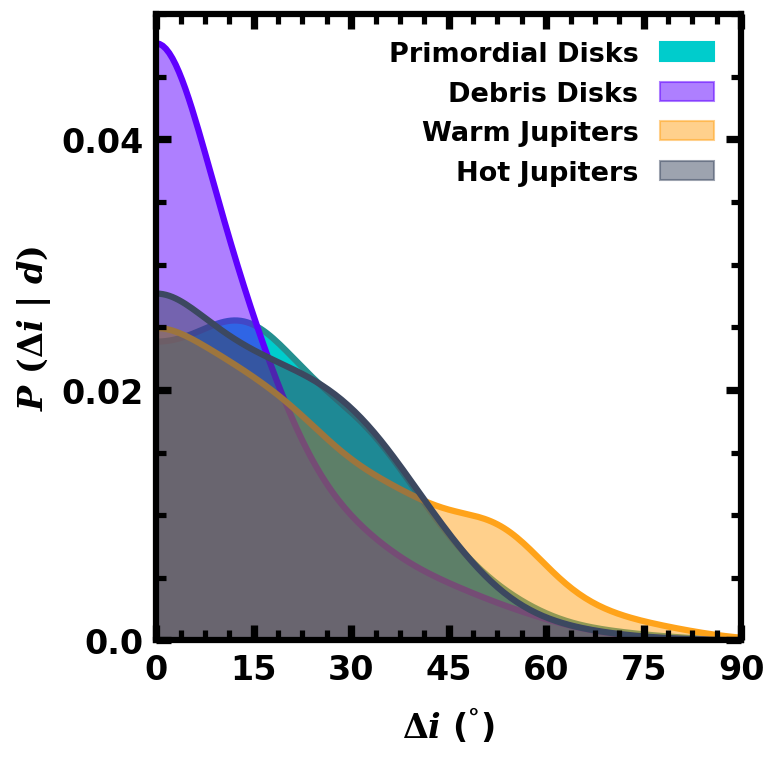

In [79]:

mpl.rcParams['hatch.linewidth'] = 2


fig = plt.figure(figsize=(5, 5), dpi=150)
ax = fig.add_subplot(111)

ax.minorticks_on()

Delta_i_hist_fontsize = 16

ax.set_xlabel(r'$\Delta i$ ($^\degree$)', fontsize=Delta_i_hist_fontsize, labelpad=10)
ax.set_ylabel(r'$P$ $(\Delta i$ | $d)$', fontsize=Delta_i_hist_fontsize)

zorder_shift = 10

# ax.fill_between(x_grid_plot_biddle, density_estimation_total_positive_x_biddle, color=pd_color, alpha=1, label='Primordial Disks', zorder=-11)
ax.plot(x_grid_plot, density_estimation_total_positive_x_biddle, color='#248f8f', alpha=1, lw=3, zorder=-11)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_biddle, color=pd_color, alpha=1, label='Primordial Disks', zorder=-12)
ax.plot(x_grid_plot, density_estimation_total_positive_x_hurt, color=dd_color, alpha=1, lw=3, zorder=-10)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_hurt, color=dd_color, alpha=0.5, label='Debris Disks', zorder=-10)
ax.plot(x_grid_plot, density_estimation_total_positive_x_morgan_WJ, color=WJ_color, lw=3, alpha=1, zorder=-9)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_morgan_WJ, color=WJ_color, alpha=0.5, label='Warm Jupiters', zorder=-9)
ax.plot(x_grid_plot, density_estimation_total_positive_x_morgan_HJ, color=HJ_color, lw=3, alpha=1, zorder=-8)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_morgan_HJ, color=HJ_color, alpha=0.5, label='Hot Jupiters', zorder=-8)
# ax.fill_between(x_grid_plot, density_estimation_total_positive_x_morgan_HJ, edgecolor=HJ_color, facecolor='None', hatch='xx', alpha=1, lw=3, label='Hot Jupiters', zorder=-8)


# ax.plot(x_grid_plot, density_estimation_total_positive_x_morgan_HJ, color=HJ_color, lw=3, alpha=1, zorder=-4)


xticks_major = [0, 15, 30, 45, 60, 75, 90]
ax.set_xticks(xticks_major, which='major')
ax.set_xticklabels(xticks_major, fontsize=Delta_i_hist_fontsize)
# ax.set_xticklabels(xticks_hist_minor, fontsize=Delta_i_hist_fontsize)
# minor_locator = AutoMinorLocator(3)
# ax.xaxis.set_minor_locator(minor_locator)
ax.set_xlim(0, 90)

yticks_hist = np.arange(0, 0.07 + 0.02, 0.02)
ax.set_yticks(yticks_hist)
ax.set_yticklabels(yticks_hist)
ax.set_ylim(0, 0.05)

ax.legend(loc='upper right', prop={'size': 13}, ncol=1, markerfirst=False)  # , bbox_to_anchor=(0.24, 0.90, 0.5, 0.10))

for spine in ax.spines.values():
    spine.set_zorder(100)

ax.tick_params(which='minor', length=5, width=2.5, labelsize=Delta_i_hist_fontsize)
ax.tick_params(which='major', length=7, width=3.5, labelsize=Delta_i_hist_fontsize)

fig.subplots_adjust(left=0.19, bottom=0.145, right=0.97, top=0.98, wspace=0.12, hspace=0.35)


save_kde_string = 'KDEs_' + resolution_text + '_' + light_or_dark_dext + '_' + transparent_text + '_' + date_str + '.pdf'

if plot_transparent == True:
    fig.savefig(test_figures_directory + save_kde_string, dpi=300, transparent=True)
else:
    fig.savefig(test_figures_directory + save_kde_string, dpi=300, transparent=False)

plt.show()
plt.close()


/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_70054/4216604406.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[ax].set_yticklabels(yticklabels)


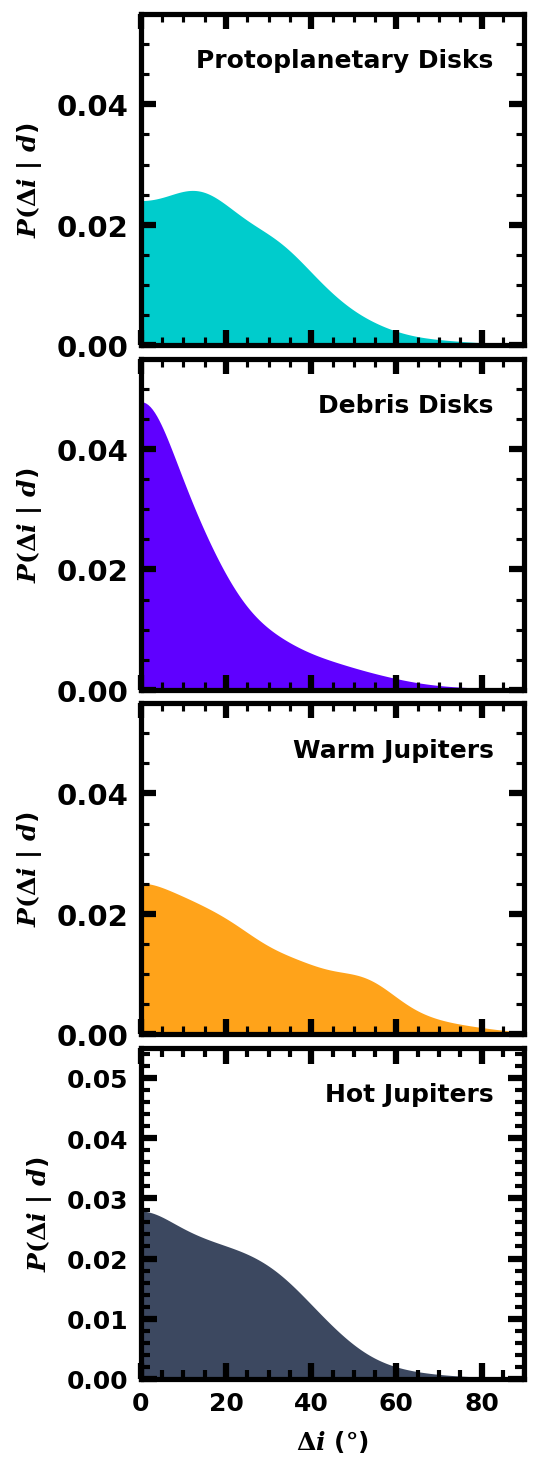

In [80]:
kde_stacked_plots_width = 3.5
kde_stacked_plots_height = 10

kde_stacked_plots_suptitlepad = 10
kde_stacked_plots_suptitle_fontsize = 14

kde_stacked_plots_labelpad = 6
kde_stacked_plots_label_fontsize = 12

kde_text_fontsize = 12


fig = plt.figure(figsize=(kde_stacked_plots_width, kde_stacked_plots_height), dpi=150)
axes = fig.subplot_mosaic(
    """
    d
    c
    b
    a
    """,
    gridspec_kw={'height_ratios': [1, 1, 1, 1], 'width_ratios': [1], "bottom": 0.07, "top": 0.98, "left": 0.25, "right": 0.98, "wspace": 0.44, "hspace": 0.04,}
)

axes['a'].set_ylim(0, 1.20*max(density_estimation_total_positive_x_morgan_HJ))
axes['b'].set_ylim(0, 1.20*max(density_estimation_total_positive_x_morgan_WJ))
axes['c'].set_ylim(0, 1.20*max(density_estimation_total_positive_x_hurt))
axes['d'].set_ylim(0, 1.20*max(density_estimation_total_positive_x_biddle))

axes['a'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)
axes['b'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)
axes['c'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)
axes['d'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)

axes['a'].set_xlabel(r'$\Delta i$ ($\degree$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)

axes['a'].fill_between(x_grid_plot, density_estimation_total_positive_x_morgan_HJ, color=HJ_color, alpha=1, zorder=-4)
axes['b'].fill_between(x_grid_plot, density_estimation_total_positive_x_morgan_WJ, color=WJ_color, alpha=1, zorder=-6)
axes['c'].fill_between(x_grid_plot, density_estimation_total_positive_x_hurt, color=dd_color, alpha=1, zorder=-9)
axes['d'].fill_between(x_grid_plot, density_estimation_total_positive_x_biddle, color=pd_color, alpha=1, zorder=-11)


axes['a'].text(0.92, 0.86, 'Hot Jupiters', horizontalalignment='right', verticalalignment='center', fontsize=kde_text_fontsize, transform=axes['a'].transAxes)
axes['b'].text(0.92, 0.86, 'Warm Jupiters', horizontalalignment='right', verticalalignment='center', fontsize=kde_text_fontsize, transform=axes['b'].transAxes)
axes['c'].text(0.92, 0.86, 'Debris Disks', horizontalalignment='right', verticalalignment='center', fontsize=kde_text_fontsize, transform=axes['c'].transAxes)
axes['d'].text(0.92, 0.86, 'Protoplanetary Disks', horizontalalignment='right', verticalalignment='center', fontsize=kde_text_fontsize, transform=axes['d'].transAxes)

axes['a'].tick_params(which='minor', length=4.5, width=2, labelsize=kde_stacked_plots_label_fontsize)
axes['a'].tick_params(which='major', length=7.5, width=3, labelsize=kde_stacked_plots_label_fontsize)

for ax in axes.keys():
    axes[ax].minorticks_on()
    axes[ax].set_rasterized(True)

    for spine in axes[ax].spines.values():
        spine.set_linewidth(2.5)

    # SPECIFY THE X TICKS
    xticks = [0, 20, 40, 60, 80]
    xticklabels = [str(int(xtick)) for xtick in xticks]
    axes[ax].set_xticks(xticks)
    if ax == 'a':
        axes[ax].set_xticklabels(xticklabels)
    else:
        axes[ax].set_xticklabels([])

    axes[ax].set_xlim(0, 90)
    axes[ax].set_ylim(0, 0.055)

    yticks = axes[ax].get_yticks()
    yticklabels = ['{:.2f}'.format(ytick) for ytick in yticks]
    yticklabels[-1] = ' '
    # print(yticklabels)
    axes[ax].set_yticklabels(yticklabels)


# SAVE THE FIGURE
save_par_vs_stacked_kde = 'Stacked_KDE_' + light_or_dark_dext + '_' + transparent_text + '_' + date_str + '.pdf'

if plot_transparent == True:
    fig.savefig(test_figures_directory + save_par_vs_stacked_kde, dpi=300, transparent=True)
else:
    fig.savefig(test_figures_directory + save_par_vs_stacked_kde, dpi=300, transparent=False)



43


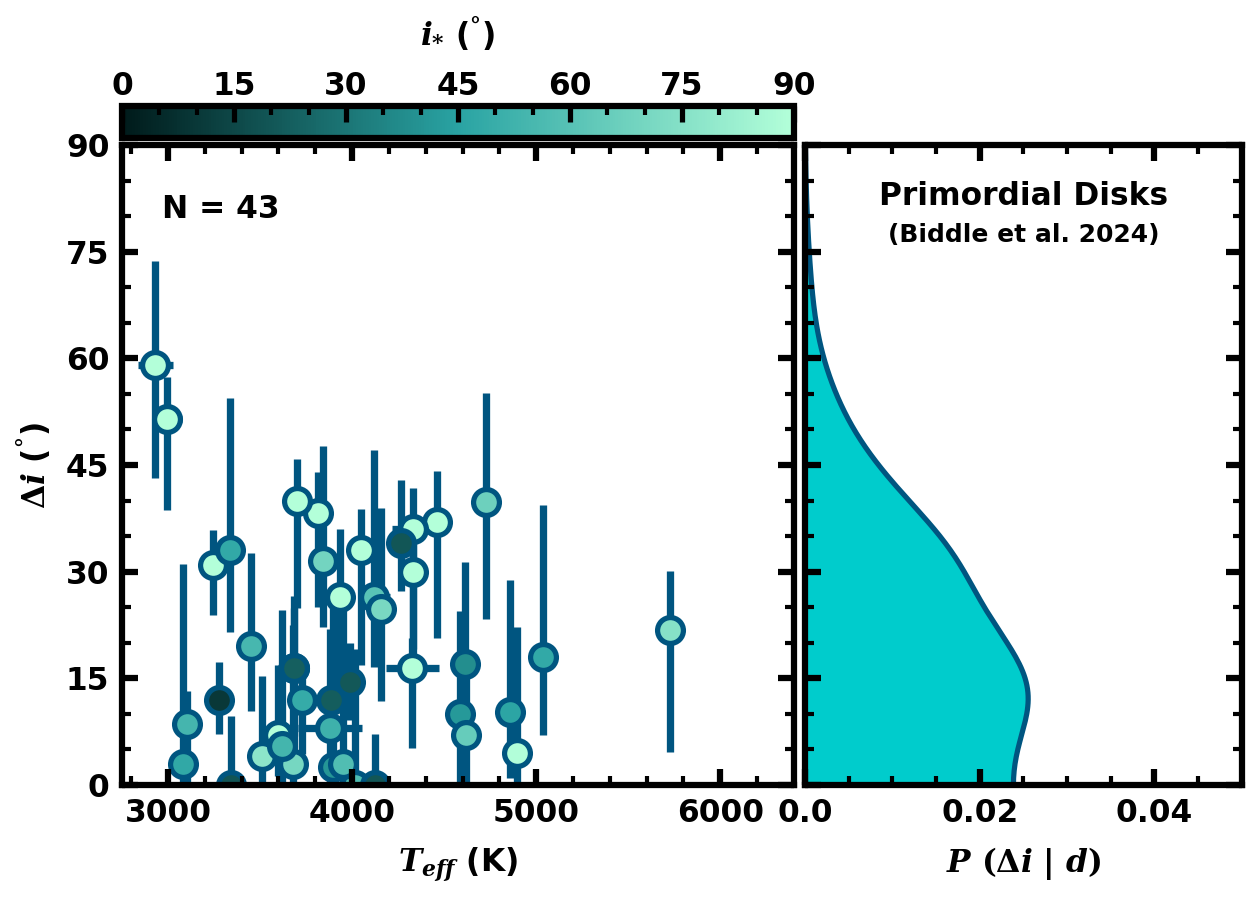

21


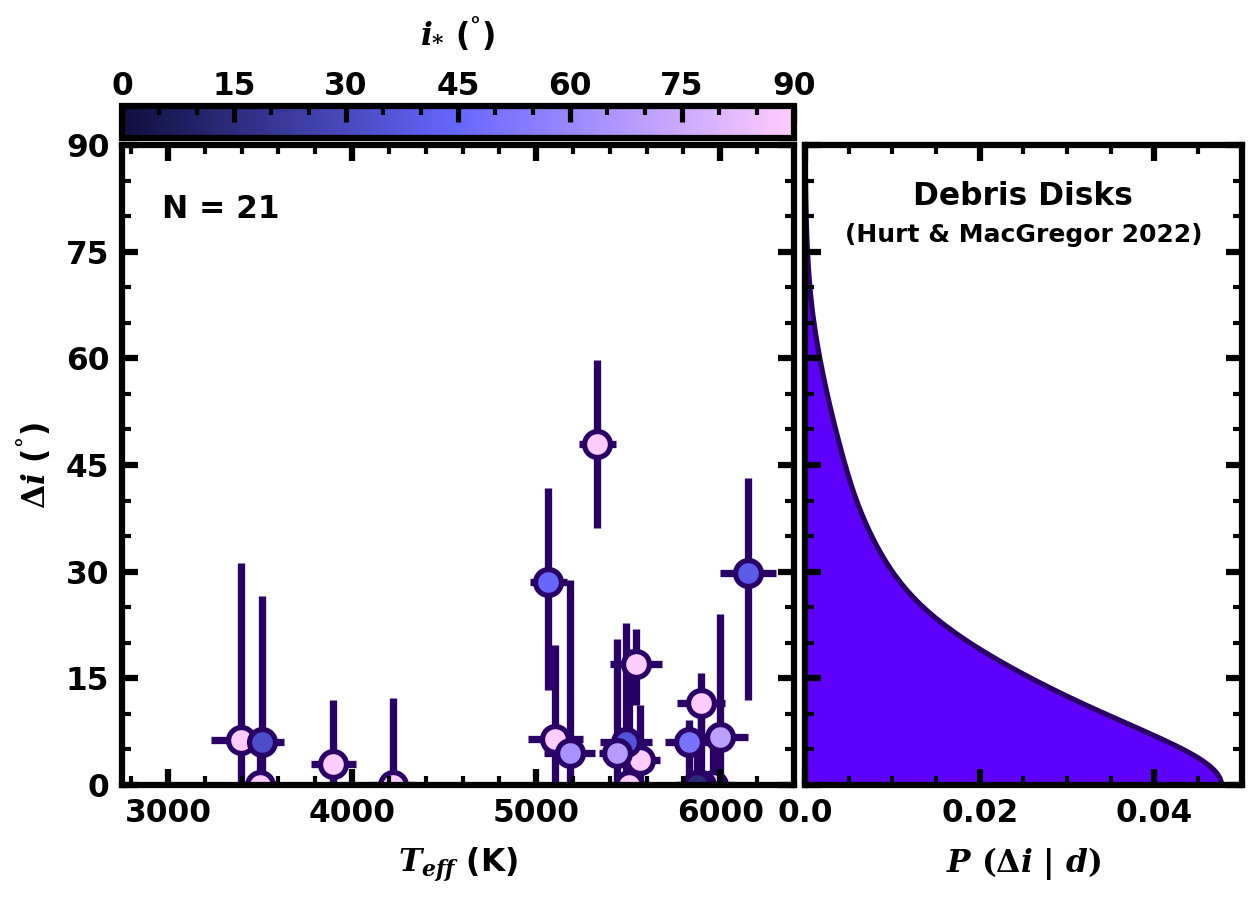

20


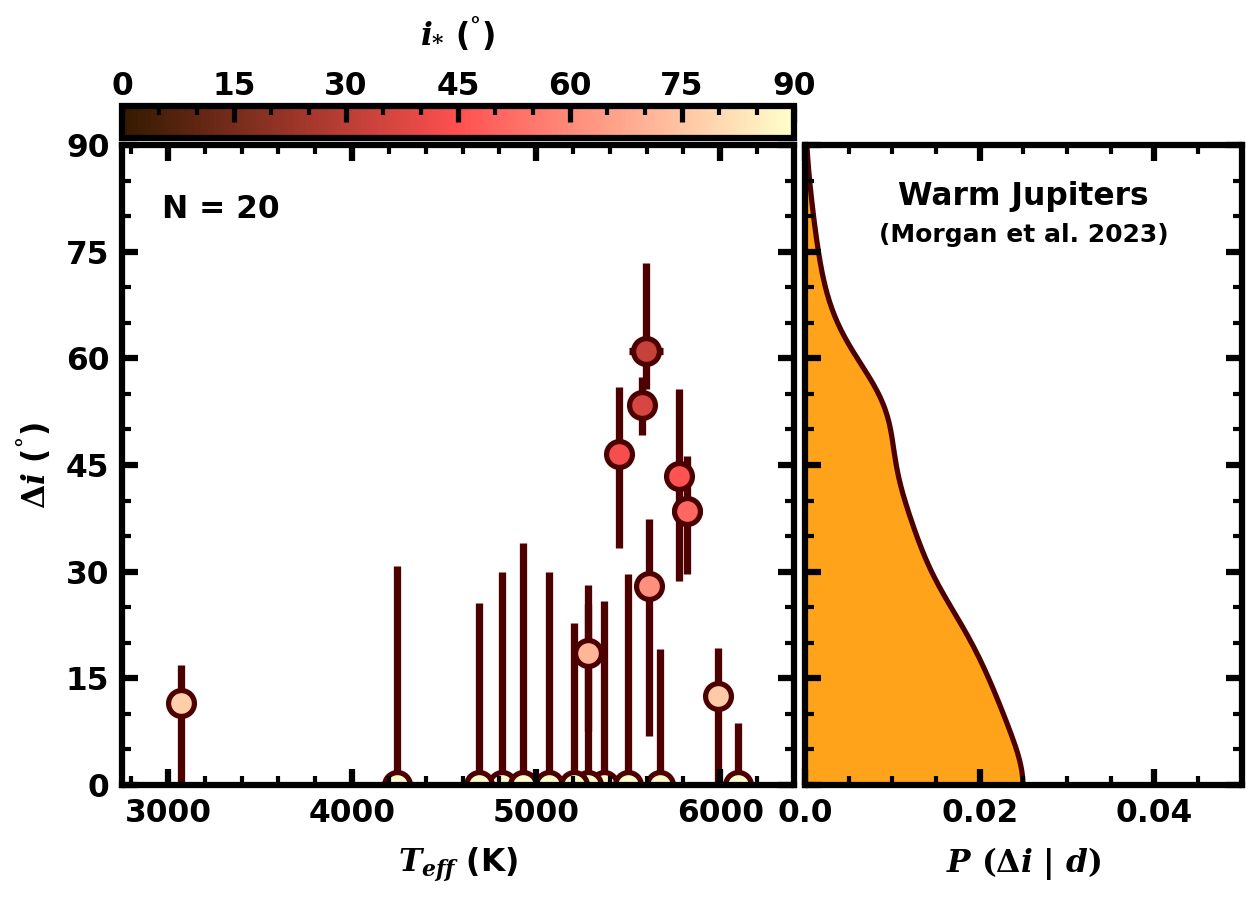

18


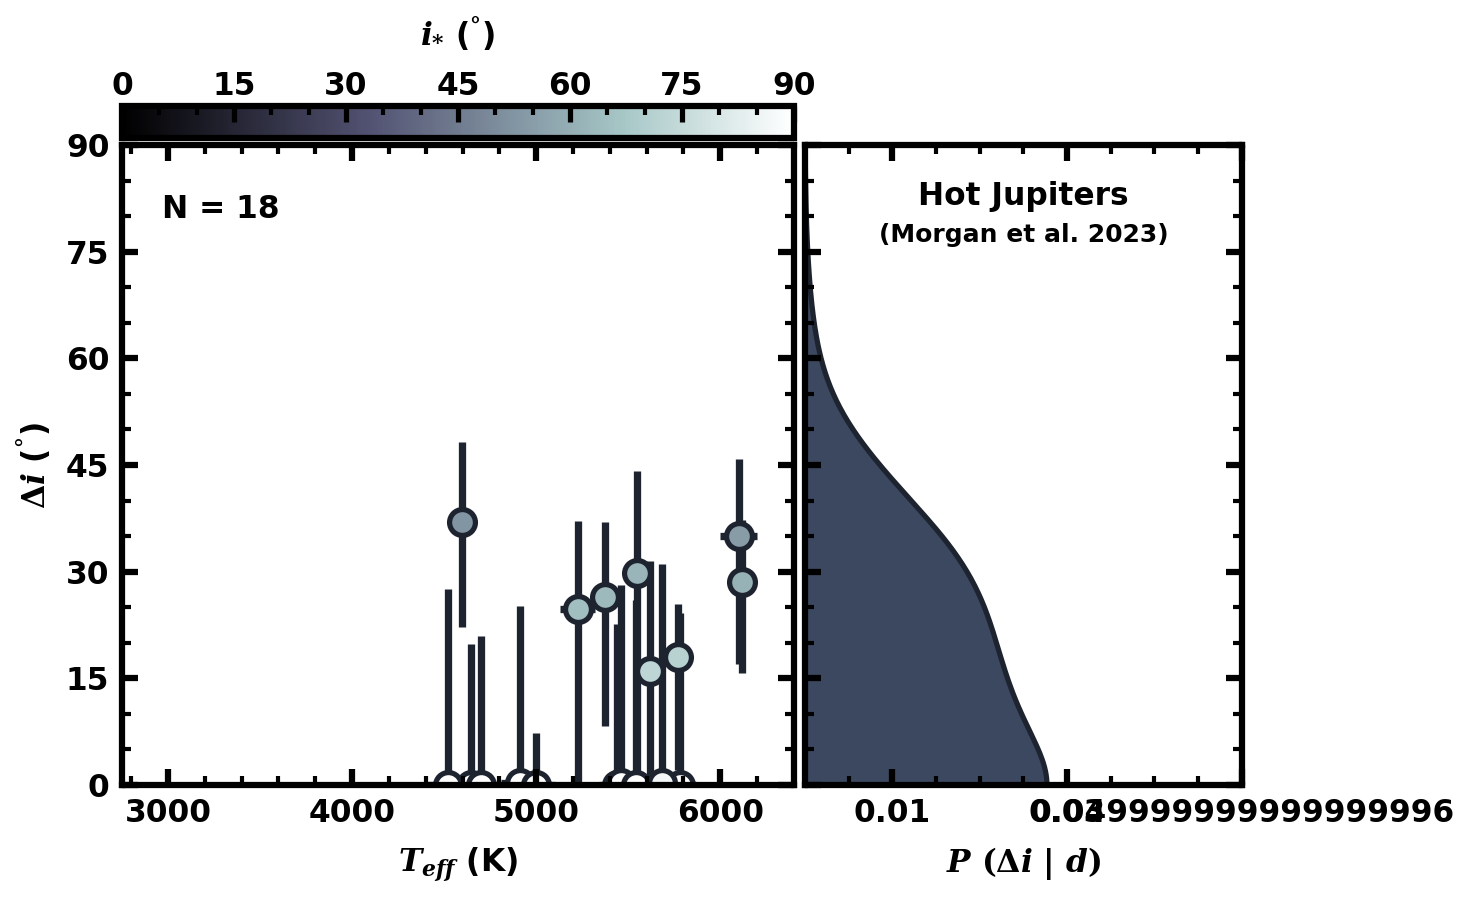

In [81]:

x_column = 'SpType'
x_column = 'Teff (K)'

if x_column == 'SpType':
    x_column_err_p = 'SpType Unc'
    x_column_err_m = 'SpType Unc'
    x_label = 'SpType'
    xlims = [2.25, 5.75]
    x_text = 'SpT'

if x_column == 'Teff (K)':
    x_column_err_p = 'Teff Unc'
    x_column_err_m = 'Teff Unc'
    x_label = r'$T_{eff}$ (K)'
    xlims = [2750, 6400]
    dx1 = 1000
    x_text = 'Teff'

y_column = 'disk diff'
y_column_err_p = 'disk diff +Unc'
y_column_err_m = 'disk diff -Unc'
y_label = r'$\Delta i$ ($^\degree$)'
ylims = [-2, 90]
y_text = 'Delta_i'

z_column = 'i star (deg)'
z_column_err_p = 'i star -Unc'
z_column_err_m = 'i star +Unc'
z_label = r'$i_{*}$ ($^\degree$)'
zlims = [0, 90]
z_text = 'i_Star'

parameter_z_norm = plt.Normalize(zlims[0], zlims[1])


datasets = ['biddle', 'hurt', 'morgan_WJ', 'morgan_HJ']

for which_dataset in datasets:

    # -------------------------------------------- #
    # --------------- WHICH TARGET --------------- #
    # which_dataset = 'biddle'
    # which_dataset = 'hurt'
    # which_dataset = 'morgan_WJ'
    # which_dataset = 'morgan_HJ'
    # -------------------------------------------- #
    # -------------------------------------------- #




    if which_dataset == 'biddle':
        plot_df = df_biddle
    if which_dataset == 'hurt':
        plot_df = df_hurt
    if which_dataset == 'morgan_WJ':
        plot_df = df_morgan_WJ
    if which_dataset == 'morgan_HJ':
        plot_df = df_morgan_HJ

    parameter_x = np.array(plot_df[x_column].values)
    parameter_x_err_p = np.array(plot_df[x_column_err_p].values)
    parameter_x_err_m = np.array(plot_df[x_column_err_m].values)
    parameter_y = np.array(plot_df[y_column].values)
    parameter_y_err_p = np.array(plot_df[y_column_err_p].values)
    parameter_y_err_m = np.array(plot_df[y_column_err_m].values)
    parameter_z = np.array(plot_df[z_column].values)
    parameter_z_err_p = np.array(plot_df[z_column_err_p].values)
    parameter_z_err_m = np.array(plot_df[z_column_err_m].values)
    targets_list = np.array(plot_df['Target'].values)

    parameter_x_err = [parameter_x_err_m, parameter_x_err_p]
    parameter_y_err = [parameter_y_err_m, parameter_y_err_p]
    parameter_z_err = [parameter_z_err_m, parameter_z_err_p]

    if which_dataset == 'biddle':
        dataset_type = 'Primordial Disks'
        dataset_author = '(Biddle et al. 2024)'
        colormap = choose_cmap('primordial disks', reverse_cmap=False)
        kde_color = pd_color
        kde_linecolor = pd_linecolor
        dx2 = 0.02
        kde_alpha = 1
        err_alpha = 1
        density_estimation_total_positive_x = density_estimation_total_positive_x_biddle
        if x_column == 'SpType':
            x2min = dx2
        if x_column == 'Teff (K)':
            x2min = 0.0
    if which_dataset == 'hurt':
        dataset_type = 'Debris Disks'
        dataset_author = r'(Hurt & MacGregor 2022)'
        colormap = choose_cmap('debris disks', reverse_cmap=False)
        kde_color = dd_color
        kde_linecolor = dd_linecolor
        dx2 = 0.02
        kde_alpha = 1
        err_alpha = 1  # 0.5
        density_estimation_total_positive_x = density_estimation_total_positive_x_hurt
        if x_column == 'SpType':
            x2min = dx2
        if x_column == 'Teff (K)':
            x2min = 0.0
    if which_dataset == 'morgan_WJ':
        dataset_type = 'Warm Jupiters'
        dataset_author = '(Morgan et al. 2023)'
        colormap = choose_cmap('warm jupiters', reverse_cmap=False)
        kde_color = WJ_color
        kde_linecolor = WJ_linecolor
        dx2 = 0.02
        kde_alpha = 1
        err_alpha = 1  # 0.5
        density_estimation_total_positive_x = density_estimation_total_positive_x_morgan_WJ
        if x_column == 'SpType':
            x2min = dx2
        if x_column == 'Teff (K)':
            x2min = 0.0
    if which_dataset == 'morgan_HJ':
        dataset_type = 'Hot Jupiters'
        dataset_author = '(Morgan et al. 2023)'
        colormap = plt.get_cmap('bone')
        kde_color = '#3c4860'  # HJ_color
        kde_linecolor = HJ_linecolor
        dx2 = 0.02
        kde_alpha = 1
        err_alpha = 1  # 0.5
        density_estimation_total_positive_x = density_estimation_total_positive_x_morgan_HJ
        if x_column == 'SpType':
            x2min = dx2
        if x_column == 'Teff (K)':
            x2min = 0.01



    point_colors = [colormap(parameter_z_norm(bep)) for bep in plot_df['i star (deg)'].values]


    grid_height = 2
    grid_width = 2

    original_fig_width = 8
    original_fig_height = 6.5

    original_width_ratios = [1, 0.40]
    original_height_ratios = [0.05, 1]


    fig_width = 8.25
    fig_height = 5.80

    try_width_ratios = [1, 0.65]
    try_height_ratios = [0.05, 1]


    single_parplot_fontsize = 15

    target_labels_on = False

    point_size = 7

    z_colors_on = True

    include_HBM_models = True

    zorder_shift = 10



    fig = plt.figure(figsize=(fig_width, fig_height), dpi=150)
    gs = gridspec.GridSpec(grid_height , grid_width , width_ratios=try_width_ratios, height_ratios=try_height_ratios)
    axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]
    cbar_ax = axes[0]
    blank_ax = axes[1]
    ax1 = axes[2]
    ax2 = axes[3]


    # MAKE INVISIBLE AXES SPINES INVISIBRU
    for spine in blank_ax.spines.values():
        spine.set_edgecolor('#ffffff')
    blank_ax.set_xticklabels([])
    blank_ax.set_yticklabels([])
    blank_ax.tick_params(axis='both', which='both', color='#ffffff')



    ax1.minorticks_on()
    ax2.minorticks_on()

    ax1.set_xlabel(x_label, fontsize=single_parplot_fontsize, labelpad=8)
    ax1.set_ylabel(r'$\Delta i$ ($^\degree$)', fontsize=single_parplot_fontsize, labelpad=6)
    ax2.set_xlabel(r'$P$ $(\Delta i$ | $d)$', fontsize=single_parplot_fontsize, labelpad=8)


    point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z]
    point_edgecolors = [kde_linecolor]*len(point_colors)  # [edge_color]*len(point_colors)
    if z_colors_on == True:
        point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z]
    else:
        point_colors = [point_color_no_z]*len(point_colors)

    print(len(parameter_y))

    # -------------------------------------- THE SAMPLE ---------------------------------------  #
    for par_i in range(0, len(parameter_y)):
        if parameter_z[par_i] == 90.0:
            zord = -4
        if parameter_z[par_i] < 90:
            zord = -1
        # print([parameter_x[par_i]], [parameter_y[par_i]])
        ax1.scatter([parameter_x[par_i]], [parameter_y[par_i]], color=point_colors[par_i], edgecolors=point_edgecolors[par_i], linewidth=2.5, s=np.pi*point_size**2, linestyle='None', zorder=zord)
        ax1.errorbar([parameter_x[par_i]], [parameter_y[par_i]], xerr=[[parameter_x_err[0][par_i]],[parameter_x_err[1][par_i]]], yerr=[[parameter_y_err[0][par_i]], [parameter_y_err[1][par_i]]],
                    elinewidth=3.5, linewidth=0, capsize=0, ecolor=point_edgecolors[par_i], capthick=0, zorder=-5, alpha=err_alpha)
    # ---------------------------------------------------------------------------------------- #


    # --------------------------------------- COLORBAR --------------------------------------- #
    if z_colors_on == True:
        # Add a single colorbar
        cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=parameter_z_norm, cmap=colormap), cax=cbar_ax, orientation='horizontal') # , use_gridspec=True, shrink=1., fraction=0.05, pad=0.02)  # location='top', 
        cbar.set_label(z_label, labelpad=12, fontsize=single_parplot_fontsize, weight='bold')  # rotation=270
        cbar_ticks = np.arange(0, 105, 15)
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticks, fontsize=single_parplot_fontsize)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')
        Number_of_minor_ticks_between_major_ticks_cbar = 3
        yticks_minor_cbar = AutoMinorLocator(Number_of_minor_ticks_between_major_ticks_cbar)
        cbar.minorticks_on()
        cbar.ax.xaxis.set_minor_locator(yticks_minor_cbar)
        cbar.ax.tick_params(which='minor', length=4.5, width=2)
        cbar.ax.tick_params(which='major', length=7.5, width=2.5, pad=2)
    # ---------------------------------------------------------------------------------------- #



    # ------------------------------ KERNEL DENSITY ESTIMATION ------------------------------- #
    ax2.fill_between(density_estimation_total_positive_x, x_grid_plot, color=kde_color, alpha=kde_alpha, label='Gaussian KDE', zorder=1-zorder_shift)
    ax2.plot(density_estimation_total_positive_x, x_grid_plot, color=kde_linecolor, alpha=kde_alpha, zorder=1-zorder_shift+1)
    # ---------------------------------------------------------------------------------------- #


    # ---------------------------------------- THE SUN ---------------------------------------  #
    Solar_SpType = 4.98  # 4.6
    Solar_SpType_err = 0.1
    Solar_obliquity = 7.155
    Solar_obliquity_err = 0.002
    Solar_point_size = 750

    sun_color = '#ffff80'  # '#ace600'
    sun_edgecolor = '#26004d'  # '#001a33'
    ax1.scatter([Solar_SpType], [Solar_obliquity], marker='*', color=sun_color, edgecolors=sun_edgecolor, linewidth=2.5, s=Solar_point_size, linestyle='None')  # , label='The Pre-main Sequence Sun')
    # ax1.errorbar([Solar_SpType], [Solar_obliquity], xerr=[Solar_SpType_err], yerr=[Solar_obliquity_err], elinewidth=3, linewidth=0, capsize=0, ecolor='#001a33', capthick=0, zorder=-1)   
    # ---------------------------------------------------------------------------------------- #

    for spine in ax2.spines.values():
        spine.set_zorder(100)


    if x_column == 'SpType':
        sptype_designations = {'0': 'B',
                            '0.5': 'B5',
                            '1': 'A0',
                            '1.5': 'A5',
                            '2': 'F0',
                            '2.5': 'F5',
                            '3': 'G0',
                            '3.5': 'G5',
                            '4': 'K0',
                            '4.5': 'K5',
                            '5': 'M0',
                            '5.5': 'M5',
                            }

        xtickvals = [2.5, 3., 3.5, 4, 4.5, 5, 5.5]  # np.arange(xlims[0], xlims[1]+0.25, 0.25)
        xticklabs = []
        xticks = []
        for xtick in xtickvals:
            if xtick < xlims[1]:
                if (np.mod(xtick,1) == 0) and (xtick >= xlims[0]):
                    xticks.append(xtick)
                    xticklabs.append(sptype_designations[str(int(xtick))])
                elif (np.mod(xtick,0.5) == 0) and (xtick >= xlims[0]):
                    xticks.append(xtick)
                    xticklabs.append(sptype_designations['{:.1f}'.format(xtick)])
        ax1.set_xticks(xticks)
        xticklabels = ax1.set_xticklabels(xticklabs, fontsize=single_parplot_fontsize)

    if x_column == 'Teff (K)':
        xticks = [3000, 4000, 5000, 6000]
        # xticks = np.arange(xlims[0], xlims[1] + dx1, dx1)
        ax1.set_xticks(xticks)
        xticklabels = ax1.set_xticklabels(xticks, fontsize=single_parplot_fontsize)


    x2lim = 0.05  # 1.15 * max(density_estimation_total_positive_x)
    ax2_xtickvals = np.arange(x2min, x2lim + dx2, dx2)
    ax2.set_xticks(ax2_xtickvals)
    ax2.set_xticklabels(ax2_xtickvals, fontsize=single_parplot_fontsize)




    ytickvals_major = np.arange(0, 105, 15)
    yticks_major = [int(ytick) for ytick in ytickvals_major]
    ax1.set_yticks(yticks_major, which='major')
    ax2.set_yticks(yticks_major, which='major')
    yticklabels = ax1.set_yticklabels(yticks_major, fontsize=single_parplot_fontsize)
    ax2.set_yticklabels([])

    Number_of_minor_ticks_between_major_ticks = 3
    yticks_minor = AutoMinorLocator(Number_of_minor_ticks_between_major_ticks) 
    ax1.yaxis.set_minor_locator(yticks_minor)
    ax2.yaxis.set_minor_locator(yticks_minor)


    ax1.set_xlim(xlims)
    ax1.set_ylim(0, 90)
    ax2.set_ylim(0, 90)
    ax2.set_xlim(0, x2lim)

    ax1.set_rasterized(True)

    ax1.tick_params(which='minor', length=4.5, width=2)
    ax1.tick_params(which='major', length=7.5, width=3, pad=6)

    ax2.tick_params(labelsize=single_parplot_fontsize)

    ax2.tick_params(which='minor', length=4.5, width=2)
    ax2.tick_params(which='major', length=7.5, width=3, pad=6)



    ax2.text(0.50, 0.92, dataset_type, horizontalalignment='center', verticalalignment='center', fontsize=single_parplot_fontsize, transform=ax2.transAxes)
    ax2.text(0.50, 0.86, dataset_author, horizontalalignment='center', verticalalignment='center', fontsize=0.8*single_parplot_fontsize, transform=ax2.transAxes)

    ax1.text(0.06, 0.90, 'N = {:d}'.format(len(parameter_y)), horizontalalignment='left', verticalalignment='center', fontsize=single_parplot_fontsize, transform=ax1.transAxes)



    fig.subplots_adjust(left=0.085, bottom=0.11, right=0.99, top=0.89, wspace=0.02, hspace=0.02)
    labels_text = 'bep'


    # SAVE THE FIGURE
    save_par_vs_Deltai_string = 'Scatter_Deltai' + light_or_dark_dext + '_' + transparent_text + '_' + which_dataset + '_' + date_str + '.pdf'

    if plot_transparent == True:
        fig.savefig(test_figures_directory + save_par_vs_Deltai_string, dpi=300, transparent=True)
    else:
        fig.savefig(test_figures_directory + save_par_vs_Deltai_string, dpi=300, transparent=False)

    plt.show()
    plt.close()

In [82]:
plot_df.columns

Index(['Target', 'SpType', 'SpType Unc', 'SpType Letter', 'SpType Letter Unc',
       'Teff (K)', 'Teff Unc', 'Mstar (Msun)', 'Mstar Unc', 'Rstar (Rsun)',
       'Rstar Unc', 'Prot (d)', 'Prot Unc', 'vsini (km/s)', 'vsini Unc',
       'i disk (deg)', 'i disk Unc', 'i star (deg)', 'i star +Unc',
       'i star -Unc', 'disk diff', 'disk diff +Unc', 'disk diff -Unc', 'Veq',
       'Veq Unc'],
      dtype='object')

In [94]:
def true_obliquity_posterior(i_star_deg, i_plane_deg, di):
    # Compute the posterior distribution conditioned on the stellar inclination angle and inclination of the disk or orbital plane

    true_obliquities_deg = np.arange(abs(i_plane_deg - i_star_deg), i_plane_deg + i_star_deg, di)
    print('true_obliquities_deg', true_obliquities_deg[0:10], '\n')
    
    true_obliquities_rad = []
    for obl in range(len(true_obliquities_deg)):
        true_obliquities_rad.append(np.radians(true_obliquities_deg[obl]))
    true_obliquities_rad = np.array(true_obliquities_rad)
    print('true_obliquities_rad', true_obliquities_rad[0:10], '\n')
    
    i_star_rad = np.radians(i_star_deg)
    i_plane_rad = np.radians(i_plane_deg)

    top = np.sin(i_star_rad) * np.sin(true_obliquities_rad)
    bottom1 = np.sin(true_obliquities_rad)**2 * np.sin(i_plane_rad)**2
    bottom2 = (np.cos(true_obliquities_rad) * np.cos(i_plane_rad) - np.cos(i_star_rad))**2
    print('top', top[0:10], '\n')
    print('bottom1', bottom1[0:10], '\n')
    print('bottom2', bottom2[0:10], '\n')

    posterior = top / np.sqrt(bottom1 - bottom2)

    true_obliquities = []
    for obl2 in range(len(true_obliquities_rad)):
        true_obliquities.append(np.degrees(true_obliquities_rad[obl2]))

    posterior = posterior / (sum(posterior) * np.diff(true_obliquities)[0])
    posterior[0] = posterior[-1]


    return true_obliquities, posterior

In [99]:
df_biddle['Target'].values

array(['2MASS J04124068+2438157', '2MASS J04155799+2746175',
       '2MASS J04202555+2700355', '2MASS J04322210+1827426',
       '2MASS J04422101+2520343', '2MASS J11004022-7619280',
       '2MASS J16083070-3828268', 'AA Tau', 'AS 209', 'BP Tau', 'CI Tau',
       'CR Cha', 'CX Tau', 'DE Tau', 'DN Tau', 'DoAr 25', 'DoAr 44',
       'EX Lup', 'FP Tau', 'FT Tau', 'GM Aur', 'GW Lup', 'IM Lup',
       'IP Tau', 'IQ Tau', 'LkCa 15', 'MP Mus', 'MY Lup', 'PDS 70',
       'RU Lup', 'RX J1615.3-3255', 'RX J1852.3-3700', 'RY Lup', 'SU Aur',
       'SY Cha', 'Sz 114', 'Sz 130', 'Sz 73', 'TW Hya', 'V1094 Sco',
       'V836 Tau', 'WSB 52', 'WSB 63'], dtype=object)

2MASS J04422101+2520343
minimum obliquity 51.5
istar 90.0
idisk 31.36
 
true_obliquities_deg [58.64 59.64 60.64 61.64 62.64 63.64 64.64 65.64 66.64 67.64] 

true_obliquities_rad [1.02346107 1.04091437 1.05836766 1.07582095 1.09327424 1.11072754
 1.12818083 1.14563412 1.16308741 1.18054071] 

top [0.85391432 0.86286674 0.87155631 0.87998041 0.88813645 0.89602196
 0.90363453 0.91097184 0.91803166 0.92481185] 

bottom1 [0.19748126 0.20164374 0.20572554 0.20972167 0.21362727 0.21743758
 0.22114796 0.22475388 0.22825096 0.23163494] 

bottom2 [0.19748126 0.18627441 0.1752848  0.16452582 0.15401059 0.1437519
 0.13376227 0.12405386 0.1146385  0.10552766] 

0 8.728659847607271e-08


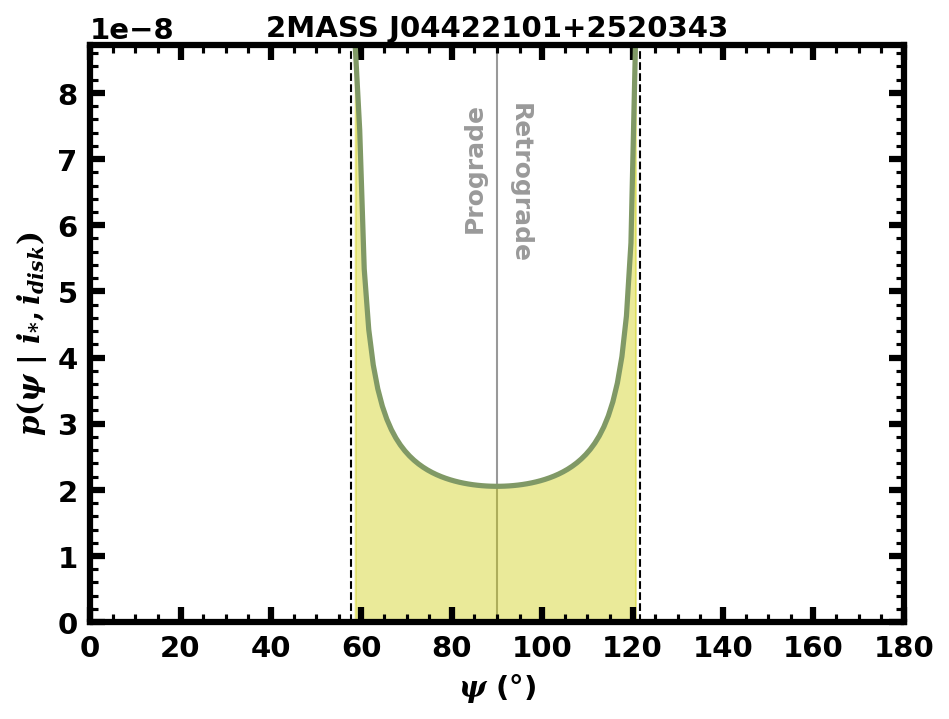

In [106]:
for test_targ in df_biddle['Target'].values:

    if test_targ == '2MASS J04422101+2520343':

        print(test_targ)
        test_df = df_biddle[df_biddle['Target'] == test_targ]

        dx = 1
        istar = test_df['i star (deg)'].values[0]
        iplane = test_df['i disk (deg)'].values[0]
        print('minimum obliquity', test_df['disk diff'].values[0])
        print('istar', istar)
        print('idisk', iplane)
        print(' ')


        plotx, ploty = true_obliquity_posterior(i_star_deg=istar, i_plane_deg=iplane, di=dx)

        print_posterior = False

        if print_posterior == True:
            for  beep in range(len(plotx)):
                print(plotx[beep], ploty[beep])


        test_fig = plt.figure(figsize=(7, 5), dpi=150)
        ax = test_fig.add_subplot(111)
        ax.minorticks_on()

        ax.set_title(test_targ)
        ax.set_xlabel(r'$\psi$ ($\degree$)')
        ax.set_ylabel(r'$p(\psi$ | $i_{*}, i_{disk})$')

        xmin, xmax = 0, 180
        ymin, ymax = 0, np.nanmax(ploty)  # -0.04 * max(ploty), 1.14 * max(ploty)
        print(ymin, ymax)

        linecolor = '#809966'  # '#476685'
        fillcolor = '#cccc00'  # '#476685'

        ax.plot(plotx, ploty, color=linecolor)
        ax.fill_between(plotx, ploty, color=fillcolor, alpha=0.4)

        ax.plot([90, 90], [0, ymax], lw=1, color='#000000', alpha=0.4, zorder = -10)
        ax.plot([np.nanmin(plotx) - dx, np.nanmin(plotx) - dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)
        ax.plot([np.nanmax(plotx) + dx, np.nanmax(plotx) + dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)

        ax.text(90 - 5, 0.90 * np.nanmax(ploty), 'Prograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=90, color='#000000', alpha=0.4)
        ax.text(90 + 5, 0.90 * np.nanmax(ploty), 'Retrograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=270, color='#000000', alpha=0.4)

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        # SAVE THE FIGURE
        save_true_obliquity_string = 'True_Obliquities/' + test_targ + '_TrueObliquity_' + light_or_dark_dext + '_' + transparent_text + '_' + which_dataset + '_' + date_str + '.pdf'

        if plot_transparent == True:
            test_fig.savefig(test_figures_directory + save_true_obliquity_string, dpi=300, transparent=True)
        else:
            test_fig.savefig(test_figures_directory + save_true_obliquity_string, dpi=300, transparent=False)

    